In [1]:
import json
import re
import pandas as pd
from pandas.io.json import json_normalize

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 110)

In [2]:
def flattenJSON(json_obj):   
    data = json.loads(json_obj)
    
    def flatten_dict(data):
        for k in list(data):
            if isinstance(data[k], dict):
                child = flatten_dict(data[k])
                for k_ in child:
                    data[k + '.' + k_] = re.sub('^u?\'(.*?)\'','\g<1>',child[k_])
                else:
                    del data[k]
        return data
    
    return flatten_dict(data)

In [3]:
def toConvertableJson(s):    
    def _convertableJson(matchObj):
        if matchObj.group(1):
            return '"'
        elif matchObj.group(2):
            return ':"False"'
        elif matchObj.group(3):
            return ':"True"'
    
    d = flattenJSON(s)
    for i,v in enumerate(d):
        if isinstance(d[v], str) and ('{' in d[v]):
            d[v] = json.loads(re.sub('(\')|(: False)|(: True)',_convertableJson, d[v]))
    return flattenJSON(json.dumps(d))

### Business

In [4]:
with open('yelp_dataset/business.json') as f:
    data = [toConvertableJson(line) for line in f]
business = pd.DataFrame(data)
#business = business.sample(frac=0.05, replace=False, random_state=1)
business.drop(['hours','attributes'], axis=1, inplace=True) # null

In [5]:
#business[business['categories'].apply(lambda x:'Coffee & Tea' in x if x is not None else False)]

In [6]:
restaurant = business[business['categories'].apply(lambda x:('Restaurants' in x) or (('Bars' in x) and ('Cigar Bars' not in x) and ('Oxygen Bars' not in x)) or ('Food' in x) or ('Coffee & Tea' in x) or ('Fast Food' in x) or ('Burger' in x) or ('Pizza' in x) or ('Sandwiches' in x) or ('Breakfast & Brunch' in x) if x is not None else False)]
restaurant = restaurant[restaurant['city']=='Las Vegas']

#### drop features(core)

In [7]:
for i in restaurant.columns:
    if 'Hair' in i:
        restaurant.drop(restaurant[(restaurant[i]=='False') | (restaurant[i]=='True')]['business_id'].index, axis=0, inplace=True)
        restaurant.drop(columns=i, axis=1, inplace=True)

#### drop features(for training)

In [8]:
for i in restaurant.columns:
    if ('hour' in i) or ('Wheelchair' in i):
        restaurant.drop(columns=i, axis=1, inplace=True)

In [9]:
restaurant[restaurant['categories'].apply(lambda x:('Nudist' in x) )]['categories'].values

array(['Nudist, Nightlife, Active Life, Beauty & Spas, Day Spas, Religious Organizations, Lounges, Bars, Adult Entertainment, Dance Clubs, Arts & Entertainment, Buddhist Temples, Social Clubs'],
      dtype=object)

#### check category

In [10]:
#category 117, max 15
# cat_col = ['Restaurants', 'Food', 'Bars', 'Fast Food', 'American Traditional)', 'Mexican', 'Coffee & Tea', 'Sandwiches', 'Pizza', 'American New)', 'Burgers', 'Breakfast & Brunch', 'Specialty Food', 'Desserts', 'Chinese', 'Italian', 'Seafood', 'Japanese', 'Bakeries', 'Ice Cream & Frozen Yogurt', 'Asian Fusion', 'Juice Bars & Smoothies', 'Wine & Spirits', 'Beer', 'Sushi Bars', 'Chicken Wings', 'Cafes', 'Salad', 'Steakhouses', 'Barbeque', 'Cocktail Bars', 'Delis', 'Pubs', 'Thai', 'Mediterranean', 'Hawaiian', 'Food Trucks', 'Korean', 'Buffets', 'Vegetarian', 'Vegan', 'Food Delivery Services', 'Diners', 'Ethnic Food', 'Hot Dogs', 'Vietnamese', 'Local Flavor', 'Wine Bars', 'Soup', 'Donuts', 'Bubble Tea', 'Latin American', 'Food Stands', 'Filipino', 'Street Vendors', 'Noodles', 'Tex-Mex', 'Dive Bars', 'Gluten-Free', 'Hookah Bars', 'French', 'Southern', 'Indian', 'Greek', 'Middle Eastern', 'Chocolatiers & Shops', 'Chicken Shop', 'Candy Stores', 'Tapas/Small Plates', 'Shaved Ice', 'Bagels', 'Comfort Food', 'Tacos', 'Tapas Bars', 'Cupcakes', 'Soul Food', 'Gastropubs', 'Ramen', 'Custom Cakes', 'Beer Bar', 'Tea Rooms', 'Cajun/Creole', 'Halal', 'Tobacco Shops', 'Dim Sum', 'Food Court', 'Poke', 'Gelato', 'Breweries', 'Cheesesteaks', 'Fruits & Veggies', 'Spanish', 'Taiwanese', 'Imported Food', 'Pretzels', 'Caribbean', 'Szechuan', 'Pakistani', 'Kosher', 'Creperies', 'Persian/Iranian', 'Salvadoran', 'Cuban', 'Seafood Markets', 'Personal Chefs', 'Hot Pot', 'Ethiopian', 'Herbs & Spices', 'Brazilian', 'Acai Bowls', 'Pasta Shops', 'Waffles', 'Patisserie/Cake Shop', 'Coffeeshops', 'Irish', 'Izakaya', 'Popcorn Shops', 'British', 'Peruvian', 'Wineries', 'Coffee Roasteries', 'Teppanyaki', 'New Mexican Cuisine', 'Live/Raw Food', 'Fish & Chips', 'Piano Bars', 'African', 'Macarons', 'Modern European', 'Lebanese', 'German', 'Singaporean', 'Pan Asian', 'Brasseries', 'Falafel', 'Russian', 'Fondue', 'Shaved Snow', 'Irish Pub', 'Mongolian', 'Afghan', 'Shanghainese', 'Venezuelan', 'Tiki Bars', 'Laotian', 'Malaysian', 'Beverage Store', 'Colombian', 'Beer Gardens', 'Argentine', 'Champagne Bars', 'Japanese Curry', 'Kebab', 'Himalayan/Nepalese', 'Puerto Rican', 'Cafeteria', 'Basque', 'Bed & Breakfast', 'Themed Cafes', 'Honey', 'Turkish', 'Whiskey Bars', 'Tuscan', 'Egyptian', 'Pub Food', 'Moroccan', 'Belgian', 'Ukrainian', 'Airsoft', 'Beach Bars', 'Guamanian', 'Brewpubs', 'Armenian', 'Arabian', 'Conveyor Belt Sushi', 'Portuguese', 'Scandinavian', 'South African', 'Pop-Up Restaurants']
# restaurant['categories'] = restaurant['categories'].map(lambda x:','.join([n.strip() for n in x.split(',') if n.strip() in cat_col]))
# restaurant.drop(restaurant[restaurant['categories'] == ''].index, axis=0, inplace=True)

In [11]:
# max(restaurant['categories'].map(lambda x : len(x.split(','))))

In [12]:
# category 88, max 12
cat_col = ['Restaurants', 'Food', 'Bars', 'Fast Food', 'Coffee & Tea', 'Sandwiches', 'Pizza', 'Burgers', 'Breakfast & Brunch', 'Specialty Food', 'Desserts', 'Seafood', 'Bakeries', 'Ice Cream & Frozen Yogurt', 'Juice Bars & Smoothies', 'Wine & Spirits', 'Beer', 'Sushi Bars', 'Cafes', 'Salad', 'Steakhouses', 'Barbeque', 'Cocktail Bars', 'Delis', 'Pubs', 'Food Trucks', 'Buffets', 'Vegetarian', 'Vegan', 'Diners', 'Hot Dogs', 'Wine Bars', 'Soup', 'Donuts', 'Bubble Tea', 'Noodles', 'Dive Bars', 'Hookah Bars', 'Chocolatiers & Shops', 'Candy Stores', 'Tapas/Small Plates', 'Shaved Ice', 'Bagels', 'Comfort Food', 'Tacos', 'Tapas Bars', 'Cupcakes', 'Soul Food', 'Ramen', 'Custom Cakes', 'Beer Bar', 'Tea Rooms', 'Cajun/Creole', 'Halal', 'Tobacco Shops', 'Dim Sum', 'Food Court', 'Poke', 'Gelato', 'Breweries', 'Cheesesteaks', 'Fruits & Veggies', 'Pretzels', 'Creperies', 'Hot Pot', 'Herbs & Spices', 'Acai Bowls', 'Pasta Shops', 'Waffles', 'Patisserie/Cake Shop', 'Coffeeshops', 'Popcorn Shops', 'Wineries', 'Live/Raw Food', 'Macarons', 'Fondue', 'Shaved Snow', 'Tiki Bars', 'Beer Gardens', 'Champagne Bars', 'Japanese Curry', 'Kebab', 'Cafeteria', 'Bed & Breakfast', 'Whiskey Bars', 'Beach Bars', 'Brewpubs', 'Conveyor Belt Sushi']
restaurant['categories'] = restaurant['categories'].map(lambda x:','.join([n.strip() for n in x.split(',') if n.strip() in cat_col]))
restaurant.drop(restaurant[restaurant['categories'] == ''].index, axis=0, inplace=True)

In [13]:
max(restaurant['categories'].map(lambda x : len(x.split(','))))

12

In [14]:
cat = []
[cat.extend(n.split(',')) for n in restaurant['categories'] if n is not None ]
cat = [n.strip() for n in cat]
cat = [(n, cat.count(n)) for n in set(cat)]
cat.sort(key=lambda e:e[1], reverse=True)
cat

[('Restaurants', 6450),
 ('Food', 3594),
 ('Bars', 1542),
 ('Fast Food', 985),
 ('Coffee & Tea', 766),
 ('Sandwiches', 741),
 ('Pizza', 686),
 ('Burgers', 622),
 ('Breakfast & Brunch', 543),
 ('Specialty Food', 541),
 ('Desserts', 481),
 ('Seafood', 398),
 ('Bakeries', 351),
 ('Ice Cream & Frozen Yogurt', 337),
 ('Wine & Spirits', 309),
 ('Beer', 309),
 ('Juice Bars & Smoothies', 309),
 ('Sushi Bars', 283),
 ('Cafes', 265),
 ('Salad', 259),
 ('Steakhouses', 254),
 ('Barbeque', 246),
 ('Cocktail Bars', 209),
 ('Delis', 206),
 ('Pubs', 189),
 ('Food Trucks', 146),
 ('Buffets', 144),
 ('Vegetarian', 138),
 ('Vegan', 137),
 ('Diners', 128),
 ('Hot Dogs', 114),
 ('Wine Bars', 94),
 ('Donuts', 89),
 ('Soup', 89),
 ('Bubble Tea', 89),
 ('Noodles', 80),
 ('Dive Bars', 79),
 ('Hookah Bars', 75),
 ('Chocolatiers & Shops', 66),
 ('Candy Stores', 64),
 ('Tapas/Small Plates', 64),
 ('Bagels', 63),
 ('Shaved Ice', 63),
 ('Comfort Food', 62),
 ('Tacos', 54),
 ('Tapas Bars', 53),
 ('Cupcakes', 50),
 (

#### check null

In [15]:
s = pd.DataFrame({'unique_count':restaurant.nunique(),'null_count':restaurant.isnull().sum()})
#s[s['unique_count']==0]
s

,unique_count,null_count
business_id,8864,0
name,6334,0
address,6057,0
city,1,0
state,2,0
postal_code,77,0
latitude,7343,0
longitude,7181,0
stars,9,0
review_count,950,0


In [16]:
restaurant

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,attributes.GoodForKids,attributes.RestaurantsReservations,attributes.Caters,attributes.NoiseLevel,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.RestaurantsPriceRange2,attributes.OutdoorSeating,attributes.BikeParking,attributes.HasTV,attributes.WiFi,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsGoodForGroups,attributes.RestaurantsDelivery,attributes.GoodForMeal.dessert,attributes.GoodForMeal.latenight,attributes.GoodForMeal.lunch,attributes.GoodForMeal.dinner,attributes.GoodForMeal.brunch,attributes.GoodForMeal.breakfast,attributes.BusinessParking.garage,attributes.BusinessParking.street,attributes.BusinessParking.validated,attributes.BusinessParking.lot,attributes.BusinessParking.valet,attributes.Ambience.romantic,attributes.Ambience.intimate,attributes.Ambience.classy,attributes.Ambience.hipster,attributes.Ambience.divey,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.Ambience.casual,attributes.BusinessAcceptsCreditCards,attributes.BusinessAcceptsBitcoin,attributes.ByAppointmentOnly,attributes.AcceptsInsurance,attributes.GoodForDancing,attributes.CoatCheck,attributes.HappyHour,attributes.Music.dj,attributes.Music.background_music,attributes.Music.no_music,attributes.Music.jukebox,attributes.Music.live,attributes.Music.video,attributes.Music.karaoke,attributes.BestNights.monday,attributes.BestNights.tuesday,attributes.BestNights.friday,attributes.BestNights.wednesday,attributes.BestNights.thursday,attributes.BestNights.sunday,attributes.BestNights.saturday,attributes.Ambience,attributes.BusinessParking,attributes.DogsAllowed,attributes.BYOBCorkage,attributes.DriveThru,attributes.Smoking,attributes.AgesAllowed,attributes.Corkage,attributes.BYOB,attributes.GoodForMeal,attributes.Music,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.gluten-free,attributes.DietaryRestrictions.vegan,attributes.DietaryRestrictions.kosher,attributes.DietaryRestrictions.halal,attributes.DietaryRestrictions.soy-free,attributes.DietaryRestrictions.vegetarian,attributes.BestNights,attributes.Open24Hours,attributes.DietaryRestrictions,attributes.RestaurantsCounterService
17,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128529,4.0,40,0,Restaurants,True,True,True,quiet,NaN,True,2,False,NaN,False,no,full_bar,casual,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,True,False,True,False,False,False,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,KWywu2tTEPWmR9JnBc0WyQ,Hunk Mansion,6007 Dean Martin Dr,Las Vegas,NV,89118,36.080168,-115.182756,4.0,107,1,Bars,False,True,NaN,loud,NaN,NaN,2,True,False,True,NaN,full_bar,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,True,False,True,False,False,False,False,False,False,False,True,NaN,NaN,NaN,True,NaN,NaN,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,6055 E Lake Mead Blvd,Las Vegas,NV,89156,36.195615,-115.040529,4.5,184,1,"Restaurants,Patisserie/Cake Shop,Food,Bars",True,False,False,average,NaN,True,1,False,True,True,no,beer_and_wine,casual,True,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,kANF0dbeoW34s2vwh6Umfw,Dairy Queen,6125 Spring Mountain Rd,Las Vegas,NV,89146,36.125031,-115.225620,2.0,33,0,"Fast Food,Food,Restaurants,Ice Cream &

In [17]:
restaurant.to_csv('./yelp_dataset/restaurant.csv')

In [18]:
#restaurant = pd.read_csv('yelp_dataset/restaurant.csv')

In [19]:
for i in restaurant.columns:
    print(restaurant[i].value_counts())

le0ZcsG2uCarJIUqj2GcLg    1
swl9MCD8CU7kbNvn0L4SJg    1
lqEbAO2I1q4ttg2LvMStqQ    1
f0160VdQERs6Y6Aq-Chvfw    1
r3kFRJuy7CTxamZycndqGw    1
                         ..
THadh2gExZ0AxzcLJbJf9g    1
YoFQBCkBc9rmuZZD_9m4Nw    1
GscGQdN5p48OfiNXr4QKsw    1
dJF4C707KVhFx1qcRJhlEA    1
u89h2EwY7Swtu_9sLtVKRw    1
Name: business_id, Length: 8864, dtype: int64
Starbucks                        145
Subway                           120
McDonald's                        87
7-Eleven                          87
Walgreens                         49
                                ... 
Steiner's                          1
Mulligan's Border Bar & Grill      1
Hammer & Ales                      1
BJ's Cocktail Lounge               1
Eat 'em Sandwiches                 1
Name: name, Length: 6334, dtype: int64
                                      171
5757 Wayne Newton Blvd                 56
3799 Las Vegas Blvd S                  38
4321 W Flamingo Rd                     33
3355 Las Vegas Blvd S           

### Review

In [20]:
with open('yelp_dataset/review.json') as f:
    data = [json.loads(line) for line in f]
review = pd.DataFrame(data)
#review = review.sample(frac=0.05, replace=False, random_state=1)

In [21]:
review

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38
...,...,...,...,...,...,...,...,...,...
6685895,0pCaq1hqAViS2N6ldlp_sQ,Xu_YazIajfsc7SRj1wJ6Mg,RXBFk3tVBxiTf3uOt9KExQ,5.0,1,0,0,I have been coming here for years and this pla...,2018-07-03 12:17:27
6685896,jPCXuSBbI_cPocgoNBhdkg,V6BjjQICDO4q7TT3ZhaPWw,yA6dKNm_zl1ucZCnwW8ZCg,1.0,13,11,5,I think this owner and the owner of Amy's Baki...,2013-05-22 15:32:08
6685897,zwzO3yPdGbdgGy3-XQ0SWg,PFiIECX8wuvi7P-1mCvIjA,a192hdM0_UVCYLwPJv1Qwg,5.0,0,0,0,"Off the grid Mexican in Vegas. Very tasty, qua...",2018-11-13 21:15:20
6685898,o8Nc2BJhKJXM6tRHJDRuPA,wu5R5_N7q5iqCBh6NBX26Q,kOo4ZY2UQAX4j312mzQ8mA,5.0,1,1,1,We hired Taco Naco to cater our family party a...,2018-08-13 18:09:16


In [22]:
#review_restaurant = review[review['business_id'].apply(lambda x:x in list(restaurant['business_id']))]
res_k = restaurant[['business_id']]
review_restaurant = res_k.merge(review, how='left',on='business_id')
review_restaurant['date'] = review_restaurant['date'].map(pd.to_datetime)

In [23]:
# replace \r
#lyNSICzFzDPHXL_E6PHvWw
review_restaurant.at[review_restaurant[review_restaurant['review_id']=='lyNSICzFzDPHXL_E6PHvWw'].index, 'text'] = review_restaurant[review_restaurant['review_id']=='lyNSICzFzDPHXL_E6PHvWw'].text.values[0].replace('\r','')
review_restaurant

,business_id,review_id,user_id,stars,useful,funny,cool,text,date
0,PZ-LZzSlhSe9utkQYU8pFg,klcF45wKIOpJW_BhJslOJg,-Yz2wIcsdJxUOFMbTgoKQA,5.0,1,0,0,"We went there for dinner the other night, bein...",2011-06-29 02:55:07
1,PZ-LZzSlhSe9utkQYU8pFg,Li-pQG6A7p5gbgZHTMeDSQ,jYcf_e5p0UG0S-9gJq_tNA,4.0,1,0,0,i had the best Chicken Marcela ever. The spagh...,2010-10-06 18:20:13
2,PZ-LZzSlhSe9utkQYU8pFg,iRLX3dJ3ONvncIxPnXy1cw,nQC0JiPIk_jCooRDxpuw5A,5.0,1,0,0,Basically the best Italian in town for the pri...,2010-01-13 00:35:45
3,PZ-LZzSlhSe9utkQYU8pFg,rklteWf9xnTU3fAtMFBRRw,Gv_-mtOKhWFtCjn9xFe0SQ,3.0,1,0,0,Mmmmm delicious food and a little history. Mr....,2008-08-23 20:30:33
4,PZ-LZzSlhSe9utkQYU8pFg,UfRqM0RGdZa86hFcFEAnjw,pabMYegF28KjHQ5hybAJ0A,3.0,1,0,0,"This is old Vegas, this atmosphere is old scho...",2009-06-01 20:02:55
...,...,...,...,...,...,...,...,...,...
1386119,vIAEWbTJc657yN8I4z7whQ,-SEmE5vSGN8VDUF18JRczA,8QKrhvVqhEkD8xo4E4s0GQ,5.0,1,0,2,The Baristas rock here! I stop in on my way to...,2012-10-05 22:04:07
1386120,vIAEWbTJc657yN8I4z7whQ,-sx8tpdUukgvh0uByg4DBQ,9ks-80ZxeCZWNObzEbW4-Q,1.0,3,4,1,This is THE worst Starbucks I've ever been to....,2015-04-01 04:34:41
1386121,vIAEWbTJc657yN8I4z7whQ,82qiOWCRRPTjRcxcIq018g,EA-UgJmd-hQ8RBn1odmDJg,3.0,0,0,0,The guy here at window just turned this whole ...,2015-03-31 21:08:21
1386122,vIAEWbTJc657yN8I4z7whQ,4U49OBNRHvjm62hcBEKy2A,bcxc4OF5SDiJ4xnNMBZUQQ,5.0,0,0,0,I honestly don't know why this location has su...,2017-12-28 06:26:37


In [24]:
review_restaurant.to_csv('./yelp_dataset/review_restaurant.csv')

### User

In [25]:
with open('yelp_dataset/user.json') as f:
    data = [json.loads(line) for line in f]
user = pd.DataFrame(data)
#user = user.sample(frac=0.05, replace=False, random_state=1)

In [26]:
user

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,95,2013-10-08 23:11:33,84,17,25,"2015,2016,2017","c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",5,4.03,2,0,0,0,0,1,1,1,1,2,0
1,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,3.63,1,0,0,0,0,0,0,1,1,0,0
2,bc8C_eETBWL0olvFSJJd0w,David,16,2013-10-04 00:16:10,28,8,10,,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",0,3.71,0,0,0,0,0,1,0,0,0,0,0
3,dD0gZpBctWGdWo9WlGuhlA,Angela,17,2014-05-22 15:57:30,30,4,14,,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",5,4.85,1,0,0,0,0,0,2,0,0,1,0
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,361,2013-10-23 07:02:50,1114,279,665,"2015,2016,2017,2018","mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",39,4.08,28,1,0,0,1,16,57,80,80,25,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637133,oC4BjbB4I-wx5KBAO1k2Gg,Jiaxin,2,2016-02-24 19:28:47,0,0,0,,None,0,4.50,0,0,0,0,0,0,0,0,0,0,0
1637134,LKd_-BT2GMWp8_1ho18kOg,Wes,8,2017-02-25 23:34:05,0,0,0,,None,0,4.00,0,0,0,0,0,0,0,0,0,0,0
1637135,ib_elCBhGOamS0AALkh4Og,Lee,4,2009-08-19 22:08:16,8,0,0,,None,0,3.40,0,0,0,0,0,0,0,0,0,0,0
1637136,WV27LoSFDG_YmiDKTLKKLA,Melissa,1,2018-10-15 17:07:43,1,0,0,,None,0,3.00,0,0,0,0,0,0,0,0,0,0,0


In [27]:
rev_k = pd.DataFrame({'user_id':review_restaurant['user_id'].unique()})
user_restaurant = rev_k.merge(user, how='left',on='user_id')

In [28]:
user_restaurant

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,-Yz2wIcsdJxUOFMbTgoKQA,Walt,72,2011-06-29 02:38:05,177,35,28,,"Sh6E0df5Y1Em-MHDeL6Nkw, 8SgjU2fID9VqKQooFt1DIQ...",2,3.42,1,0,0,0,0,2,1,3,3,0,0
1,jYcf_e5p0UG0S-9gJq_tNA,Fred,21,2009-02-05 00:22:04,32,9,5,,None,1,2.86,0,0,0,0,0,0,2,0,0,0,0
2,nQC0JiPIk_jCooRDxpuw5A,N,18,2010-01-12 23:10:51,34,16,2,,None,0,3.89,0,0,0,0,0,1,0,0,0,0,0
3,Gv_-mtOKhWFtCjn9xFe0SQ,Crysta,149,2008-06-23 19:08:04,170,59,81,,"pWVy4iCapVG-3DDb6celgA, GGWjA8v479feCo6OPTLQOg...",24,4.05,26,5,1,3,1,6,7,10,10,2,0
4,pabMYegF28KjHQ5hybAJ0A,Steve,59,2009-03-03 16:53:04,45,10,12,,"KGBfVdXlMRP9OoP8PusISg, mJLRvqLOKhqEdkgt9iEaCQ...",2,3.80,1,0,0,0,0,0,0,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464328,_77s6LTBJ4BrDoR1phYiWg,Tim,12,2012-02-24 19:31:33,6,0,2,,None,0,3.47,0,0,0,0,0,0,0,0,0,0,0
464329,cSb3VUePA0vk_oH8-_nAMg,Aaron,5,2012-03-05 21:04:21,0,0,1,,"ipKpAtbJiziTg2uCnf2mDQ, tgfTT6wbnOmsuMs52TbeEA...",0,4.20,0,0,0,0,0,0,0,0,0,0,0
464330,5F_1TgQWAncO2qkodeu2PA,Ashley,1,2014-11-24 21:49:22,0,0,0,,None,0,1.00,0,0,0,0,0,0,0,0,0,0,0
464331,bmANZOzkp7ztoFhdPdnjHg,Rose,15,2011-01-27 00:30:21,20,11,9,,None,0,3.47,1,0,0,0,0,0,1,0,0,0,0


#### NLP

In [ ]:
import nltk
from gensim.models.word2vec import Word2Vec
import string

In [ ]:
#stopword 목록 다운로드
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

In [ ]:
translator = str.maketrans('', '', string.punctuation)

In [ ]:
review_restaurant['text'] = review_restaurant['text'].astype(str)

In [ ]:
# each.translate(translator) == 특수문자 제거
# x.lower() == 소문자화
# if x.lower() not in stop_words == 불용어제거
clean = [[x.lower() for x in each.translate(translator).split() if x.lower() not in stop_words] for each in review_restaurant['text'].values]

In [ ]:
clean

In [ ]:
#### it takes too long.

# model = Word2Vec(clean,window=5,min_count=100,sg=1,iter=1000)

# print(list(model.wv.vocab.keys()))
# print("vocab length : %d"%len(model.wv.vocab))

In [ ]:
review_restaurant['text'].map(lambda x : len(x.split(' '))).describe()

In [ ]:
review_restaurant

In [ ]:
review_txt = review_restaurant['text'].to_list()
review_label = review_restaurant['business_id'].to_list()

#### tokenize

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 20000  # We will be training on 20000 samples
validation_samples = 5000  # We will be validating on 5000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
# Sequence of all the training samples, with word indexing replacing the actual word.
sequences = tokenizer.texts_to_sequences(texts)
print(sequences[0])

# A sorted dictionary that saves the index of each word, from the most frequent to the least frequent
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
print(data[0])

### Check in

In [29]:
with open('yelp_dataset/checkin.json') as f:
    data = [json.loads(line) for line in f]
checkin = pd.DataFrame(data)
#checkin = checkin.sample(frac=0.05, replace=False, random_state=1)
checkin

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010..."
...,...,...
161945,zzvlwkcNR1CCqOPXwuvz2A,"2017-05-06 20:05:15, 2017-05-12 22:37:03, 2017..."
161946,zzwaS0xn1MVEPEf0hNLjew,"2010-02-16 02:09:56, 2010-07-05 05:40:48, 2010..."
161947,zzwhN7x37nyjP0ZM8oiHmw,"2016-03-06 13:27:02, 2016-03-09 00:41:53, 2016..."
161948,zzwicjPC9g246MK2M1ZFBA,"2012-09-22 00:26:15, 2012-09-23 20:12:00, 2012..."


### Tip (not use)

In [30]:
with open('yelp_dataset/tip.json') as f:
    data = [json.loads(line) for line in f]
tip = pd.DataFrame(data)
#tip = tip.sample(frac=0.05, replace=False, random_state=1)
tip

,user_id,business_id,text,date,compliment_count
0,UPw5DWs_b-e2JRBS-t37Ag,VaKXUpmWTTWDKbpJ3aQdMw,"Great for watching games, ufc, and whatever el...",2014-03-27 03:51:24,0
1,Ocha4kZBHb4JK0lOWvE0sg,OPiPeoJiv92rENwbq76orA,Happy Hour 2-4 daily with 1/2 price drinks and...,2013-05-25 06:00:56,0
2,jRyO2V1pA4CdVVqCIOPc1Q,5KheTjYPu1HcQzQFtm4_vw,Good chips and salsa. Loud at times. Good serv...,2011-12-26 01:46:17,0
3,FuTJWFYm4UKqewaosss1KA,TkoyGi8J7YFjA6SbaRzrxg,The setting and decoration here is amazing. Co...,2014-03-23 21:32:49,0
4,LUlKtaM3nXd-E4N4uOk_fQ,AkL6Ous6A1atZejfZXn1Bg,Molly is definately taking a picture with Sant...,2012-10-06 00:19:27,0
...,...,...,...,...,...
1223089,nus5X9JKgU_SzfAL4vhJrg,qdwwiRKwnhdlr9QcgJuzbg,"Very good class, great instructor!!",2018-08-05 20:58:09,0
1223090,95wqYGU6-OiHqRPZP0uAWw,wrs4Zbz17q_G49AIRxRPVw,Excellent food,2018-08-15 18:05:22,0
1223091,HtLaONYabidSxMS1eGHcXA,wEc4JE2NYQr1RnGjGr4q7w,Jess is the best bartender!! Go check her out!,2018-10-02 03:34:58,0
1223092,T4R5ZKfcGt1GIAgjCh67eA,n5Hc_iMVkyxcS0SXiBCbOQ,Excellent food and AMAZING service by Anneliese!!,2018-10-13 16:57:50,0


------------------------------
### matrix factorization test

In [29]:
import matplotlib.pyplot as plt
import numpy as np

import os
import plaidml.keras
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [30]:
res_train = restaurant[:500]
res_train

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,attributes.GoodForKids,attributes.RestaurantsReservations,attributes.Caters,attributes.NoiseLevel,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.RestaurantsPriceRange2,attributes.OutdoorSeating,attributes.BikeParking,attributes.HasTV,attributes.WiFi,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsGoodForGroups,attributes.RestaurantsDelivery,attributes.GoodForMeal.dessert,attributes.GoodForMeal.latenight,attributes.GoodForMeal.lunch,attributes.GoodForMeal.dinner,attributes.GoodForMeal.brunch,attributes.GoodForMeal.breakfast,attributes.BusinessParking.garage,attributes.BusinessParking.street,attributes.BusinessParking.validated,attributes.BusinessParking.lot,attributes.BusinessParking.valet,attributes.Ambience.romantic,attributes.Ambience.intimate,attributes.Ambience.classy,attributes.Ambience.hipster,attributes.Ambience.divey,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.Ambience.casual,attributes.BusinessAcceptsCreditCards,attributes.BusinessAcceptsBitcoin,attributes.ByAppointmentOnly,attributes.AcceptsInsurance,attributes.GoodForDancing,attributes.CoatCheck,attributes.HappyHour,attributes.Music.dj,attributes.Music.background_music,attributes.Music.no_music,attributes.Music.jukebox,attributes.Music.live,attributes.Music.video,attributes.Music.karaoke,attributes.BestNights.monday,attributes.BestNights.tuesday,attributes.BestNights.friday,attributes.BestNights.wednesday,attributes.BestNights.thursday,attributes.BestNights.sunday,attributes.BestNights.saturday,attributes.Ambience,attributes.BusinessParking,attributes.DogsAllowed,attributes.BYOBCorkage,attributes.DriveThru,attributes.Smoking,attributes.AgesAllowed,attributes.Corkage,attributes.BYOB,attributes.GoodForMeal,attributes.Music,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.gluten-free,attributes.DietaryRestrictions.vegan,attributes.DietaryRestrictions.kosher,attributes.DietaryRestrictions.halal,attributes.DietaryRestrictions.soy-free,attributes.DietaryRestrictions.vegetarian,attributes.BestNights,attributes.Open24Hours,attributes.DietaryRestrictions,attributes.RestaurantsCounterService
17,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128529,4.0,40,0,Restaurants,True,True,True,quiet,NaN,True,2,False,NaN,False,no,full_bar,casual,True,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,True,False,True,False,False,False,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,KWywu2tTEPWmR9JnBc0WyQ,Hunk Mansion,6007 Dean Martin Dr,Las Vegas,NV,89118,36.080168,-115.182756,4.0,107,1,Bars,False,True,NaN,loud,NaN,NaN,2,True,False,True,NaN,full_bar,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,True,False,True,False,False,False,False,False,False,False,True,NaN,NaN,NaN,True,NaN,NaN,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,6055 E Lake Mead Blvd,Las Vegas,NV,89156,36.195615,-115.040529,4.5,184,1,"Restaurants,Patisserie/Cake Shop,Food,Bars",True,False,False,average,NaN,True,1,False,True,True,no,beer_and_wine,casual,True,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,kANF0dbeoW34s2vwh6Umfw,Dairy Queen,6125 Spring Mountain Rd,Las Vegas,NV,89146,36.125031,-115.225620,2.0,33,0,"Fast Food,Food,Restaurants,Ice Cream &

In [31]:
rev_train = res_train[['business_id']].merge(review_restaurant, on='business_id',how='left')
rev_train

,business_id,review_id,user_id,stars,useful,funny,cool,text,date
0,PZ-LZzSlhSe9utkQYU8pFg,klcF45wKIOpJW_BhJslOJg,-Yz2wIcsdJxUOFMbTgoKQA,5.0,1,0,0,"We went there for dinner the other night, bein...",2011-06-29 02:55:07
1,PZ-LZzSlhSe9utkQYU8pFg,Li-pQG6A7p5gbgZHTMeDSQ,jYcf_e5p0UG0S-9gJq_tNA,4.0,1,0,0,i had the best Chicken Marcela ever. The spagh...,2010-10-06 18:20:13
2,PZ-LZzSlhSe9utkQYU8pFg,iRLX3dJ3ONvncIxPnXy1cw,nQC0JiPIk_jCooRDxpuw5A,5.0,1,0,0,Basically the best Italian in town for the pri...,2010-01-13 00:35:45
3,PZ-LZzSlhSe9utkQYU8pFg,rklteWf9xnTU3fAtMFBRRw,Gv_-mtOKhWFtCjn9xFe0SQ,3.0,1,0,0,Mmmmm delicious food and a little history. Mr....,2008-08-23 20:30:33
4,PZ-LZzSlhSe9utkQYU8pFg,UfRqM0RGdZa86hFcFEAnjw,pabMYegF28KjHQ5hybAJ0A,3.0,1,0,0,"This is old Vegas, this atmosphere is old scho...",2009-06-01 20:02:55
...,...,...,...,...,...,...,...,...,...
69332,M5Nvx_jkTf56Ne7tuXgCLQ,wNL9-iEOeymqZE1cSNtulg,h4iPN4TWksMntu93CI_CMw,1.0,0,0,0,Terrible experience! This place literally to t...,2013-08-02 23:41:06
69333,M5Nvx_jkTf56Ne7tuXgCLQ,EeVDQQXDRiES2Fuf-aON_A,sNxhoIvKgkq72y1D8ZFnbA,4.0,0,0,0,Ordered the Chicken Strips. Pretty tasty. Food...,2014-03-23 05:42:28
69334,M5Nvx_jkTf56Ne7tuXgCLQ,sJIbOspywi9lVgTw9sn99w,1L8K5_K-4YcpXJOADNhiJg,5.0,0,0,0,My favorite thing about this restaurant is how...,2015-04-09 00:02:27
69335,M5Nvx_jkTf56Ne7tuXgCLQ,8rJCGcmC0alhr7a2XdX1jA,Clj5WdwsjRRBvN5byPvdlA,2.0,1,1,0,"Got a flyer, so decided to give it a shot. \n\...",2013-05-05 23:24:49


In [32]:
usr_train = rev_train[['user_id']].merge(user_restaurant, on='user_id',how='left')
usr_train

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,-Yz2wIcsdJxUOFMbTgoKQA,Walt,72,2011-06-29 02:38:05,177,35,28,,"Sh6E0df5Y1Em-MHDeL6Nkw, 8SgjU2fID9VqKQooFt1DIQ...",2,3.42,1,0,0,0,0,2,1,3,3,0,0
1,jYcf_e5p0UG0S-9gJq_tNA,Fred,21,2009-02-05 00:22:04,32,9,5,,None,1,2.86,0,0,0,0,0,0,2,0,0,0,0
2,nQC0JiPIk_jCooRDxpuw5A,N,18,2010-01-12 23:10:51,34,16,2,,None,0,3.89,0,0,0,0,0,1,0,0,0,0,0
3,Gv_-mtOKhWFtCjn9xFe0SQ,Crysta,149,2008-06-23 19:08:04,170,59,81,,"pWVy4iCapVG-3DDb6celgA, GGWjA8v479feCo6OPTLQOg...",24,4.05,26,5,1,3,1,6,7,10,10,2,0
4,pabMYegF28KjHQ5hybAJ0A,Steve,59,2009-03-03 16:53:04,45,10,12,,"KGBfVdXlMRP9OoP8PusISg, mJLRvqLOKhqEdkgt9iEaCQ...",2,3.80,1,0,0,0,0,0,0,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69332,h4iPN4TWksMntu93CI_CMw,Raymundo,26,2010-05-15 07:10:27,14,1,5,,"Uj9wLzwjrA95SB2VWKkPPg, jwvmw22-y4eMq2rzi0wAeQ...",0,4.20,0,1,0,0,0,0,0,0,0,0,0
69333,sNxhoIvKgkq72y1D8ZFnbA,Bryan,11,2013-03-31 06:35:14,14,2,1,,"C8S8JNdr211p4Cu16jF8Dw, gEBRecs8QUw9kxlbqIN_sA",0,2.73,1,0,0,0,0,0,0,0,0,0,0
69334,1L8K5_K-4YcpXJOADNhiJg,Ty',5,2015-01-01 04:56:54,2,0,2,,"HCmxn_UisYXYVh5PkGsMrw, mu4XvWvJOb3XpG1C_CHCWA...",0,4.00,0,0,0,0,0,0,0,0,0,0,0
69335,Clj5WdwsjRRBvN5byPvdlA,Angie,115,2012-07-10 19:24:31,102,10,22,"2016,2017","cUN-qHxdswwDS17HV2oPhg, zv0MVTY5PTYb1O7KqVTIuw...",0,3.45,0,0,0,0,0,3,0,0,0,0,1


In [33]:
rev_train.groupby('user_id').agg({'user_id':'count'})

,user_id
user_id,
---1lKK3aKOuomHnwAkAow,2
---udAKDsn0yQXmzbWQNSw,1
--2vR0DIsmQ6WfcSzKWigw,1
--7oh57FmI8_IHX0Q4n-Wg,1
--D8T8lqv2YnX8BebVQBdg,2
...,...
zzHSF3oCjXqgsYuVJPgdvw,1
zzLd9D_UwmsL1mlyNlIa_w,1
zzPvEodjvLPe-5NvV0U_cg,14


In [34]:
rev_train_temp = rev_train.copy()
rev_train_temp.business_id = rev_train_temp.business_id.astype('category').cat.codes.values
rev_train_temp.user_id = rev_train_temp.user_id.astype('category').cat.codes.values

In [35]:
from sklearn.model_selection import train_test_split
rev_train_temp = rev_train_temp[['business_id','user_id','stars','date']]
train, test = train_test_split(rev_train_temp, random_state=777)

In [36]:
train.dtypes

business_id             int16
user_id                 int32
stars                 float64
date           datetime64[ns]
dtype: object

In [37]:
train

,business_id,user_id,stars,date
3026,227,51924,4.0,2012-02-01 06:37:45
38088,195,37601,5.0,2012-04-08 23:22:20
17161,269,6741,4.0,2009-06-26 05:55:42
38479,195,19297,4.0,2015-07-26 16:46:06
39744,333,27301,4.0,2014-05-07 17:56:16
...,...,...,...,...
69114,362,26448,1.0,2018-05-26 23:59:29
17369,269,12044,5.0,2016-05-14 18:25:51
54941,202,51395,4.0,2013-02-01 20:40:12
52134,144,44770,2.0,2014-07-21 19:15:54


In [38]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_business = len(train.user_id.unique()), len(train.business_id.unique())
n_latent_factors = 5

In [39]:
business_input = keras.layers.Input(shape=[1],name='Business')
business_embedding = keras.layers.Embedding(n_business + 1, n_latent_factors, name='business-Embedding')(business_input)
business_vec = keras.layers.Flatten(name='FlattenBusiness')(business_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.dot([business_vec, user_vec], name='DotProduct', axes=1)
model = keras.Model([user_input, business_input], prod)
model.compile('adam', 'mean_squared_error')

INFO:plaidml:Opening device "metal_amd_radeon_pro_vega_20.0"


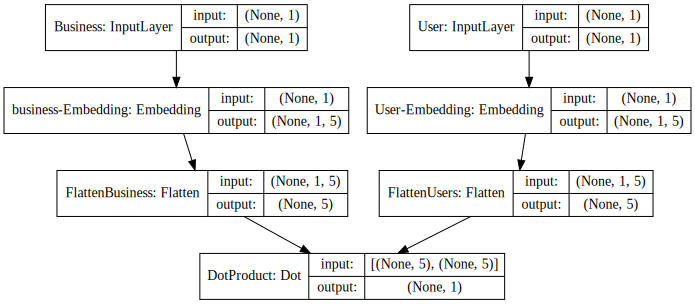

In [40]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [224]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Business (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
business-Embedding (Embedding)  (None, 1, 5)         2500        Business[0][0]                   
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         204280      User[0][0]                       
__________________________________________________________________________________________________
FlattenBus

#### train

In [236]:
history = model.fit([train.user_id, train.business_id], train.stars, epochs=100, verbose=0)

Text(0, 0.5, 'Train Error')

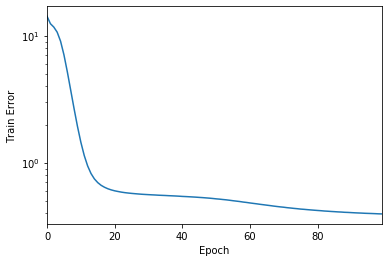

In [237]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [238]:
y_hat = np.round(model.predict([test.user_id, test.business_id]),0)
y_true = test.stars

In [239]:
np.round(model.predict([[21387], test.business_id]),0)

array([[-0.]], dtype=float32)

In [240]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

2.459821171041246

In [241]:
business_embedding_learnt = model.get_layer(name='business-Embedding').get_weights()[0]
pd.DataFrame(business_embedding_learnt).describe()

,0,1,2,3,4
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-1.786224,-1.943883,-1.838864,-1.990174,1.806344
std,0.999558,0.951664,1.161904,1.150820,1.238528
min,-3.751278,-4.289556,-5.090249,-5.336202,-1.626036
25%,-2.545964,-2.612790,-2.638820,-2.712415,1.038729
50%,-1.928630,-2.004793,-1.851157,-2.111560,1.841538
75%,-1.210229,-1.386853,-1.053700,-1.383517,2.652944
max,1.630400,1.556972,1.326942,2.391536,5.333212


In [242]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2,3,4
count,40856.000000,40856.000000,40856.000000,40856.000000,40856.000000
mean,-0.261389,-0.262061,-0.261592,-0.259915,0.259915
std,0.194471,0.189565,0.204378,0.198326,0.196759
min,-1.444574,-1.423113,-1.626124,-1.909374,-1.751477
25%,-0.406971,-0.408029,-0.412223,-0.408784,0.070948
50%,-0.307659,-0.310098,-0.309095,-0.307019,0.305154
75%,-0.075666,-0.078321,-0.059931,-0.071259,0.407778
max,1.050075,0.962363,0.956930,1.297135,1.695060


In [243]:
pd.DataFrame({'s':y_hat[:,0]}).groupby('s').agg({'s':'count'})

,s
s,
-4.0,1
-3.0,2
-1.0,8
0.0,9155
1.0,295
2.0,617
3.0,2138
4.0,3473
5.0,1350


#### non-negative matrix factorization

In [ ]:
from keras.constraints import non_neg

business_input = keras.layers.Input(shape=[1],name='Business')
business_embedding = keras.layers.Embedding(n_business + 1, n_latent_factors, name='NonNegBusiness-Embedding', embeddings_constraint=non_neg())(business_input)
business_vec = keras.layers.Flatten(name='FlattenBusiness')(business_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding', embeddings_constraint=non_neg())(user_input))

prod = keras.layers.dot([business_vec, user_vec], name='DotProduct', axes=1)
model = keras.Model([user_input, business_input], prod)
model.compile('adam', 'mean_squared_error')

#### use neural-network

In [41]:
n_latent_factors_user = 5
n_latent_factors_business = 8

business_input = keras.layers.Input(shape=[1],name='Business')
business_embedding = keras.layers.Embedding(n_business + 1, n_latent_factors_business, name='Business-Embedding')(business_input)
business_vec = keras.layers.Flatten(name='FlattenBusiness')(business_embedding)
business_vec = keras.layers.Dropout(0.2)(business_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.concatenate([business_vec, user_vec], name='Concat', axis=1)
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='softmax',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, business_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

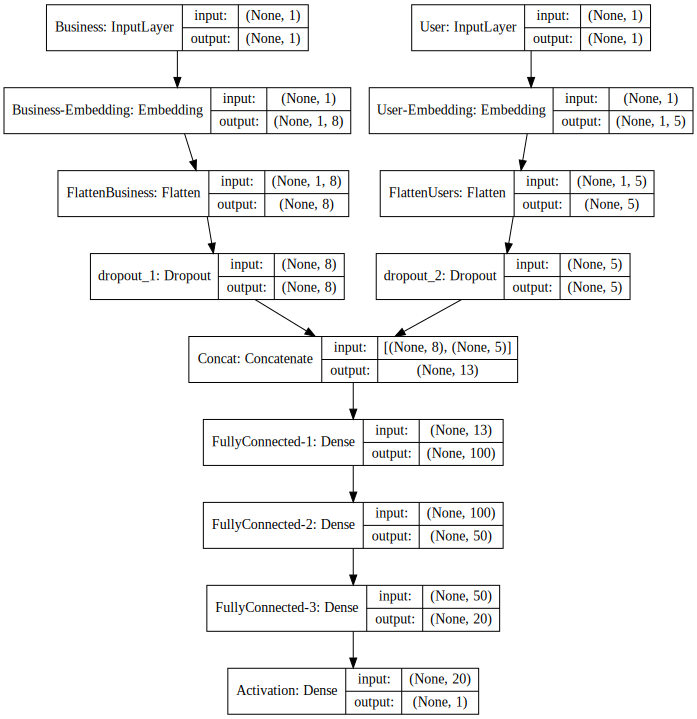

In [42]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [246]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Business (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Business-Embedding (Embedding)  (None, 1, 8)         4000        Business[0][0]                   
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         204280      User[0][0]                       
__________________________________________________________________________________________________
FlattenBus

In [247]:
history = model.fit([train.user_id, train.business_id], train.stars, epochs=250, verbose=0)

Text(0, 0.5, 'Train Error')

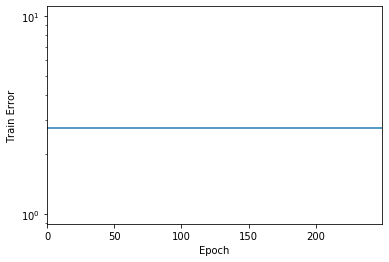

In [248]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [249]:
y_hat_2 = np.round(model.predict([test.user_id, test.business_id]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.user_id, test.business_id])))

2.7329102970868187
2.7329102970868187


In [250]:
pd.DataFrame({'s':y_hat_2[:,0]}).groupby('s').agg({'s':'count'})

,s
s,
1.0,17335


In [ ]:
test.groupby('stars').agg({'stars':'count'})

#### factorization machine

In [24]:
import keras
from keras.layers import Layer, Dense, Dropout,Input
from keras import Model,activations
from keras.optimizers import Adam
import keras.backend as K
from sklearn.datasets import load_breast_cancer

Using TensorFlow backend.


In [25]:
class FMLayer(Layer):
    def __init__(self, output_dim=30, activation="relu", **kwargs):
        self.output_dim = output_dim
        self.activate = activations.get(activation)
        super(FMLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.weight = self.add_weight(name='weight', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='glorot_uniform',
                                      trainable=True)
        self.bias = self.add_weight(name='bias', 
                                      shape=(self.output_dim,),
                                      initializer='zeros',
                                      trainable=True)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='glorot_uniform',
                                      trainable=True)
        super(FMLayer, self).build(input_shape)

    def call(self, x):
        feature =  K.dot(x,self.weight) + self.bias
        a = K.pow(K.dot(x,self.kernel), 2)
        b = K.dot(x, K.pow(self.kernel, 2))
        cross = K.mean(a-b, 1, keepdims=True)*0.5
        cross = K.repeat_elements(K.reshape(cross, (-1, 1)), self.output_dim, axis=-1)
        return self.activate(feature + cross)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [94]:
data = train
target = train['stars']

In [116]:
K.clear_session()
inputs = Input(shape=(4,))
out = FMLayer(1)(inputs)
out = Dense(15,activation="sigmoid")(out)
out = Dense(1,activation="relu")(out)

model = Model(inputs=inputs, outputs=out)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_vega_20.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
fm_layer_7 (FMLayer)         (None, 1)                 9         
_________________________________________________________________
dense_11 (Dense)             (None, 1, None, 15)       30        
_________________________________________________________________
dense_12 (Dense)             (None, 1, None, 1)        16        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


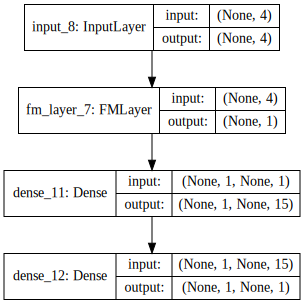

In [117]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [86]:
model.fit(data, target,
            batch_size=1,
            epochs=100,
            validation_split=0.2)

ValueError: Error when checking target: expected dense_6 to have 4 dimensions, but got array with shape (51988, 1)

-----------------------------
### Deep Factorization Model

#### backup datset

In [44]:
review_restaurant_backup = review_restaurant.copy()
user_restaurant_backup = user_restaurant.copy()
restaurant_backup = restaurant.copy()

#### restore dataset

In [55]:
review_restaurant = review_restaurant_backup.copy()
user_restaurant = user_restaurant_backup.copy()
restaurant = restaurant_backup.copy()

#### transform dataset for test

In [143]:
review_restaurant.groupby('user_id').agg({'business_id':'count'}).sort_values('business_id',ascending=False)[:21739]

,business_id
user_id,
bLbSNkLggFnqwNNzzq-Ijw,1643
PKEzKWv_FktMm2mGPjwd0Q,1182
U4INQZOPSUaj8hMjLlZ3KA,928
UYcmGbelzRa0Q6JqzLoguw,842
n86B7IkbU20AkxlFX_5aew,807
...,...
M7fdMfZHbBGIyQXpH2CTXA,10
19vrb34mUzOATpuXExUKNw,10
Kkfz5p-jYhRC5iiqWFGe2w,10


In [57]:
# select user by restaurant_count
user_index = review_restaurant.groupby('user_id').agg({'business_id':'count'}).sort_values('business_id',ascending=False)[:21739].index
review_restaurant = review_restaurant[review_restaurant.user_id.isin(user_index)]

In [58]:
review_restaurant.groupby('business_id').agg({'user_id':'count'}).sort_values('user_id',ascending=False).describe()

,user_id
count,8655.000000
mean,62.474986
std,123.319230
min,1.000000
25%,6.000000
50%,19.000000
75%,63.000000
max,2150.000000


In [59]:
review_restaurant

,business_id,review_id,user_id,stars,useful,funny,cool,text,date
1,PZ-LZzSlhSe9utkQYU8pFg,Li-pQG6A7p5gbgZHTMeDSQ,jYcf_e5p0UG0S-9gJq_tNA,4.0,1,0,0,i had the best Chicken Marcela ever. The spagh...,2010-10-06 18:20:13
2,PZ-LZzSlhSe9utkQYU8pFg,iRLX3dJ3ONvncIxPnXy1cw,nQC0JiPIk_jCooRDxpuw5A,5.0,1,0,0,Basically the best Italian in town for the pri...,2010-01-13 00:35:45
3,PZ-LZzSlhSe9utkQYU8pFg,rklteWf9xnTU3fAtMFBRRw,Gv_-mtOKhWFtCjn9xFe0SQ,3.0,1,0,0,Mmmmm delicious food and a little history. Mr....,2008-08-23 20:30:33
4,PZ-LZzSlhSe9utkQYU8pFg,UfRqM0RGdZa86hFcFEAnjw,pabMYegF28KjHQ5hybAJ0A,3.0,1,0,0,"This is old Vegas, this atmosphere is old scho...",2009-06-01 20:02:55
5,PZ-LZzSlhSe9utkQYU8pFg,1RtC0WIuMR5x88uoFOPyEA,F_N4NyoMJWzBYFspeYfH3A,4.0,0,0,0,"Heavy on the atmosphere, heavy on the red sauc...",2010-05-22 16:54:57
...,...,...,...,...,...,...,...,...,...
1386119,vIAEWbTJc657yN8I4z7whQ,-SEmE5vSGN8VDUF18JRczA,8QKrhvVqhEkD8xo4E4s0GQ,5.0,1,0,2,The Baristas rock here! I stop in on my way to...,2012-10-05 22:04:07
1386120,vIAEWbTJc657yN8I4z7whQ,-sx8tpdUukgvh0uByg4DBQ,9ks-80ZxeCZWNObzEbW4-Q,1.0,3,4,1,This is THE worst Starbucks I've ever been to....,2015-04-01 04:34:41
1386121,vIAEWbTJc657yN8I4z7whQ,82qiOWCRRPTjRcxcIq018g,EA-UgJmd-hQ8RBn1odmDJg,3.0,0,0,0,The guy here at window just turned this whole ...,2015-03-31 21:08:21
1386122,vIAEWbTJc657yN8I4z7whQ,4U49OBNRHvjm62hcBEKy2A,bcxc4OF5SDiJ4xnNMBZUQQ,5.0,0,0,0,I honestly don't know why this location has su...,2017-12-28 06:26:37


In [60]:
rev_k = pd.DataFrame({'user_id':review_restaurant['user_id'].unique()})
user_restaurant = rev_k.merge(user_restaurant, how='left',on='user_id')
res_k = pd.DataFrame({'business_id':review_restaurant['business_id'].unique()})
restaurant = res_k.merge(restaurant, how='left',on='business_id')

In [40]:
# select restaurant by user_count
business_index = review_restaurant.groupby('business_id').agg({'user_id':'count'}).sort_values('user_id',ascending=False)[:100].index
review_restaurant = review_restaurant[review_restaurant.business_id.isin(business_index)]

In [41]:
review_restaurant.groupby('user_id').agg({'business_id':'count'}).sort_values('business_id',ascending=False).describe()

,business_id
count,18584.000000
mean,4.522116
std,4.836813
min,1.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,100.000000


#### load data

In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

n_max_category = 12
n_category = 88

def load_reviews():
    df = review_restaurant.copy()
    return df[['business_id','user_id','stars','useful','funny','cool','date']]

def load_restaurants():
    df = restaurant.copy()
    df = df.rename(columns={'stars':'restaurant_stars'})
    return df[['business_id','name','restaurant_stars','review_count','categories']]

def load_users():
    df = user_restaurant.copy()
    df = df.rename(columns={'review_count':'user_review_count','useful':'user_useful','funny':'user_funny','cool':'user_cool'})
    return df[['user_id','user_review_count','user_useful','user_funny','user_cool','fans','average_stars']]

def text2seq(text, n_category):
    """ using tokenizer to encoded the multi-level categorical feature
    """
    tokenizer = Tokenizer(lower=True, split=',',filters='', num_words=n_category)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=n_max_category, padding='post')
    return seq

reviews = load_reviews()
restaurants = load_restaurants()
users = load_users()

print("====== review ======")
print(reviews.head())
print("===== restaurant ======")
print(restaurants.head())
print("====== user ======")
print(users.head())

====== review ======
              business_id                 user_id  stars  useful  funny  cool  \
1  PZ-LZzSlhSe9utkQYU8pFg  jYcf_e5p0UG0S-9gJq_tNA    4.0       1      0     0   
2  PZ-LZzSlhSe9utkQYU8pFg  nQC0JiPIk_jCooRDxpuw5A    5.0       1      0     0   
3  PZ-LZzSlhSe9utkQYU8pFg  Gv_-mtOKhWFtCjn9xFe0SQ    3.0       1      0     0   
4  PZ-LZzSlhSe9utkQYU8pFg  pabMYegF28KjHQ5hybAJ0A    3.0       1      0     0   
5  PZ-LZzSlhSe9utkQYU8pFg  F_N4NyoMJWzBYFspeYfH3A    4.0       0      0     0   

                 date  
1 2010-10-06 18:20:13  
2 2010-01-13 00:35:45  
3 2008-08-23 20:30:33  
4 2009-06-01 20:02:55  
5 2010-05-22 16:54:57  
===== restaurant ======
              business_id                                 name  \
0  PZ-LZzSlhSe9utkQYU8pFg           Carluccio's Tivoli Gardens   
1  KWywu2tTEPWmR9JnBc0WyQ                         Hunk Mansion   
2  tstimHoMcYbkSC4eBA1wEg  Maria's Mexican Restaurant & Bakery   
3  kANF0dbeoW34s2vwh6Umfw                          Dairy Que

In [62]:
restaurants['categories'] = text2seq(restaurants.categories.values, n_category=n_category).tolist()

reviews = reviews.join(restaurants.set_index('business_id'), on = 'business_id', how = 'left')
reviews = reviews.join(users.set_index('user_id'), on = 'user_id', how = 'left')

reviews['bid'] = reviews.business_id
reviews['uid'] = reviews.user_id
reviews.business_id = reviews.business_id.astype('category').cat.codes.values
reviews.user_id = reviews.user_id.astype('category').cat.codes.values

print("====== preprocessed data =======")
(reviews.head())

====== preprocessed data =======


,business_id,user_id,stars,useful,funny,cool,date,name,restaurant_stars,review_count,categories,user_review_count,user_useful,user_funny,user_cool,fans,average_stars,bid,uid
1,3585,16135,4.0,1,0,0,2010-10-06 18:20:13,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,32,9,5,1,2.86,PZ-LZzSlhSe9utkQYU8pFg,jYcf_e5p0UG0S-9gJq_tNA
2,3585,17440,5.0,1,0,0,2010-01-13 00:35:45,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",18,34,16,2,0,3.89,PZ-LZzSlhSe9utkQYU8pFg,nQC0JiPIk_jCooRDxpuw5A
3,3585,6281,3.0,1,0,0,2008-08-23 20:30:33,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",149,170,59,81,24,4.05,PZ-LZzSlhSe9utkQYU8pFg,Gv_-mtOKhWFtCjn9xFe0SQ
4,3585,18189,3.0,1,0,0,2009-06-01 20:02:55,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",59,45,10,12,2,3.80,PZ-LZzSlhSe9utkQYU8pFg,pabMYegF28KjHQ5hybAJ0A
5,3585,5806,4.0,0,0,0,2010-05-22 16:54:57,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",401,436,118,107,9,3.60,PZ-LZzSlhSe9utkQYU8pFg,F_N4NyoMJWzBYFspeYfH3A


In [63]:
# backup
reviews_backup = reviews.copy()

In [53]:
# restore
reviews = reviews_backup.copy()

In [64]:
reviews

,business_id,user_id,stars,useful,funny,cool,date,name,restaurant_stars,review_count,categories,user_review_count,user_useful,user_funny,user_cool,fans,average_stars,bid,uid
1,3585,16135,4.0,1,0,0,2010-10-06 18:20:13,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,32,9,5,1,2.86,PZ-LZzSlhSe9utkQYU8pFg,jYcf_e5p0UG0S-9gJq_tNA
2,3585,17440,5.0,1,0,0,2010-01-13 00:35:45,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",18,34,16,2,0,3.89,PZ-LZzSlhSe9utkQYU8pFg,nQC0JiPIk_jCooRDxpuw5A
3,3585,6281,3.0,1,0,0,2008-08-23 20:30:33,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",149,170,59,81,24,4.05,PZ-LZzSlhSe9utkQYU8pFg,Gv_-mtOKhWFtCjn9xFe0SQ
4,3585,18189,3.0,1,0,0,2009-06-01 20:02:55,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",59,45,10,12,2,3.80,PZ-LZzSlhSe9utkQYU8pFg,pabMYegF28KjHQ5hybAJ0A
5,3585,5806,4.0,0,0,0,2010-05-22 16:54:57,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",401,436,118,107,9,3.60,PZ-LZzSlhSe9utkQYU8pFg,F_N4NyoMJWzBYFspeYfH3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386119,8019,3327,5.0,1,0,2,2012-10-05 22:04:07,Starbucks,3.0,138,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",879,3457,1524,1927,105,3.56,vIAEWbTJc657yN8I4z7whQ,8QKrhvVqhEkD8xo4E4s0GQ
1386120,8019,3773,1.0,3,4,1,2015-04-01 04:34:41,Starbucks,3.0,138,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",535,2969,1732,2032,102,3.84,vIAEWbTJc657yN8I4z7whQ,9ks-80ZxeCZWNObzEbW4-Q
1386121,8019,5313,3.0,0,0,0,2015-03-31 21:08:21,Starbucks,3.0,138,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",116,122,41,18,2,2.06,vIAEWbTJc657yN8I4z7whQ,EA-UgJmd-hQ8RBn1odmDJg
1386122,8019,13509,5.0,0,0,0,2017-12-28 06:26:37,Starbucks,3.0,138,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",48,52,20,33,4,3.58,vIAEWbTJc657yN8I4z7whQ,bcxc4OF5SDiJ4xnNMBZUQQ


In [152]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def define_input_layers():
    # numerica features
    user_review_input = Input((1,), name = 'input_user_review')
    user_review_input2 = Input((1,), name = 'input_user_review2')
    user_review_input3 = Input((1,), name = 'input_user_review3')
    user_review_input4 = Input((1,), name = 'input_user_review4')
    user_review_input5 = Input((1,), name = 'input_user_review5')
    user_review_input6 = Input((1,), name = 'input_user_review6')
    business_info_input = Input((1,), name = 'input_business_info')
    business_info_input2 = Input((1,), name = 'input_business_info2')
    #num_inputs = [user_review_input,user_review_input2,user_review_input3,user_review_input4,user_review_input5,user_review_input6, business_info_input, business_info_input2]
    num_inputs = [user_review_input,user_review_input2,user_review_input3]
    
    # single level categorical features
    user_id_input = Input((1,), name = 'input_user_id')
    business_id_input = Input((1,), name= 'input_business_id')
    cat_sl_inputs = [user_id_input, business_id_input]

    # multi level categorical features
    categories_input = Input((n_max_category,), name = 'input_categories')
    cat_ml_inputs = [categories_input]

    inputs = num_inputs + cat_sl_inputs + cat_ml_inputs
    
    return inputs

inputs = define_input_layers()

In [153]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

def fm_1d(inputs, n_user_id, n_business_id, n_categories):
    
    #user_review_input,user_review_input2,user_review_input3,user_review_input4,user_review_input5,user_review_input6, business_info_input,business_info_input2, user_id_input, business_id_input, categories_input = inputs
    user_review_input,user_review_input2,user_review_input3, user_id_input, business_id_input, categories_input = inputs
    
    # all tensors are reshape to (None, 1)
    num_dense_1d = [Dense(1, name = 'num_dense_1d_user_review')(user_review_input),
                    Dense(1, name = 'num_dense_1d_user_review2')(user_review_input2),
                    Dense(1, name = 'num_dense_1d_user_review3')(user_review_input3),
#                     Dense(1, name = 'num_dense_1d_user_review4')(user_review_input),
#                     Dense(1, name = 'num_dense_1d_user_review5')(user_review_input),
#                     Dense(1, name = 'num_dense_1d_user_review6')(user_review_input),
#                     Dense(1, name = 'num_dense_1d_business_info')(business_info_input),
#                     Dense(1, name = 'num_dense_1d_business_info2')(business_info_input2)
                   ]
    cat_sl_embed_1d = [Embedding(n_user_id + 1, 1, name = 'cat_embed_1d_user_id')(user_id_input),
                       Embedding(n_business_id + 1, 1, name = 'cat_embed_1d_business_id')(business_id_input)]
    cat_ml_embed_1d = [Embedding(n_categories + 1, 1, mask_zero=True, name = 'cat_embed_1d_categories')(categories_input)]

    #num_dense_1d = [Reshape((1,))(i) for i in num_dense_1d]
    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = 'embed_1d_mean')(i) for i in cat_ml_embed_1d]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d + cat_ml_embed_1d)
    
    return y_fm_1d

y_1d = fm_1d(inputs, 10, 10, 10)

In [154]:
def fm_2d(inputs, n_user_id, n_business_id, n_categories, k):
    
    #user_review_input,user_review_input2,user_review_input3,user_review_input4,user_review_input5,user_review_input6, business_info_input,business_info_input2, user_id_input, business_id_input, categories_input = inputs
    user_review_input, user_review_input2,user_review_input3, user_id_input, business_id_input, categories_input = inputs
    
    num_dense_2d = [Dense(k, name = 'num_dense_2d_user_review')(user_review_input),
                    Dense(k, name = 'num_dense_2d_user_review2')(user_review_input2),
                    Dense(k, name = 'num_dense_2d_user_review3')(user_review_input3),
#                     Dense(k, name = 'num_dense_2d_user_review4')(user_review_input4),
#                     Dense(k, name = 'num_dense_2d_user_review5')(user_review_input5),
#                     Dense(k, name = 'num_dense_2d_user_review6')(user_review_input6),
#                     Dense(k, name = 'num_dense_2d_business_info')(business_info_input),
#                     Dense(k, name = 'num_dense_2d_business_info2')(business_info_input2)
                   ] # shape (None, k)
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d] # shape (None, 1, k)

    cat_sl_embed_2d = [Embedding(n_user_id + 1, k, name = 'cat_embed_2d_user_id')(user_id_input), 
                       Embedding(n_business_id + 1, k, name = 'cat_embed_2d_business_id')(business_id_input)] # shape (None, 1, k)
    
    cat_ml_embed_2d = [Embedding(n_categories + 1, k, name = 'cat_embed_2d_categories')(categories_input)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = 'cat_embed_2d_categories_mean', keepdims=True)(i) for i in cat_ml_embed_2d] # shape (None, 1, k)

    # concatenate all 2d embed layers => (None, ?, k)
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d + cat_ml_embed_2d)

    # calcuate the interactions by simplication
    # sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)

    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)

    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d

y_fm2_d, embed_2d = fm_2d(inputs, 10, 10, 10, 5)

In [155]:
def deep_part(embed_2d, dnn_dim, dnn_dr):
    
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation='relu')(y_dnn)
    y_dnn = Dense(1, activation='relu', name = 'deep_output')(y_dnn)
    
    return y_dnn

y_dnn = deep_part(embed_2d, [64, 64, 32], 0.5)

In [156]:
def deep_fm_model(n_user_id, n_business_id, n_categories, k, dnn_dim, dnn_dr):
    
    inputs = define_input_layers()
    
    y_fm_1d = fm_1d(inputs, n_user_id, n_business_id, n_categories)
    y_fm_2d, embed_2d = fm_2d(inputs, n_user_id, n_business_id, n_categories, k)
    y_dnn = deep_part(embed_2d, dnn_dim, dnn_dr)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(1, name = 'deepfm_output')(y)
    
    fm_model_1d = Model(inputs, y_fm_1d)
    fm_model_2d = Model(inputs, y_fm_2d)
    deep_model = Model(inputs, y_dnn)
    deep_fm_model = Model(inputs, y)
    
    return fm_model_1d, fm_model_2d, deep_model, deep_fm_model

In [157]:
params = {
    'n_user_id': reviews.user_id.max(),
    'n_business_id': reviews.business_id.max(),
    'n_categories': n_category,
    'k':16,
    'dnn_dim':[64, 128, 64],
    'dnn_dr': 0.5
}

fm_model_1d, fm_model_2d, deep_model, deep_fm_model = deep_fm_model(**params)

In [158]:
def df2xy(reviews):
    x = [#np.array([reviews.user_review_count.values, reviews.user_useful.values,reviews.user_funny.values,reviews.user_cool.values,reviews.fans.values,reviews.average_stars.values,]).reshape(-1,6),
#          reviews.user_review_count.values, 
#          reviews.user_useful.values,
#          reviews.user_funny.values,
#          reviews.user_cool.values,
#          reviews.fans.values,
#          reviews.average_stars.values,
#          reviews.restaurant_stars.values,#np.array([reviews.restaurant_stars.values, reviews.review_count.values]).reshape(-1,2), 
#          reviews.review_count.values,
         reviews.restaurant_stars.values,
         reviews.review_count.values,
         reviews.average_stars.values,
         reviews.user_id.values, 
         reviews.business_id.values, 
         np.concatenate(reviews.categories.values).reshape(-1,n_max_category)]
    y = reviews.stars.values
    return x,y

in_train_flag = np.random.random(len(reviews)) <= 0.9
train_data = reviews.loc[in_train_flag,]
valid_data = reviews.loc[~in_train_flag,]
train_x, train_y = df2xy(train_data)
valid_x, valid_y = df2xy(valid_data)

<BarContainer object of 9 artists>

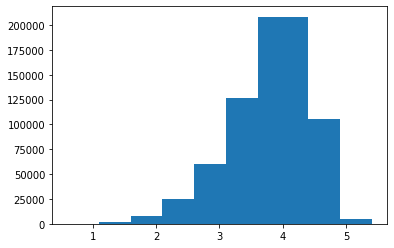

In [159]:
plt.bar(pd.DataFrame(reviews.restaurant_stars.values).iloc[:,0].value_counts().index,pd.DataFrame(reviews.restaurant_stars.values).iloc[:,0].value_counts().values)

In [160]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
# train  model
deep_fm_model.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(lr=0.01))
#mean_squared_logarithmic_error

In [161]:
deep_fm_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_user_review (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_user_review2 (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_user_review3 (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_categories (InputLayer)   [(None, 12)]         0                                            
____________________________________________________________________________________________

In [162]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model_ckp = ModelCheckpoint(filepath='./model/deepfm_weights.h5', 
                            monitor='val_loss',
                            save_weights_only=True, 
                            save_best_only=True)
callbacks = [model_ckp,early_stop]
train_history = deep_fm_model.fit(train_x, train_y,
                                  epochs=500, batch_size=2048, 
                                  validation_split=0.1, 
                                  callbacks = callbacks)

Train on 437946 samples, validate on 48661 samples
Epoch 1/500
437946/437946 [==============================] - 4s 10us/sample - loss: 5680.0200 - val_loss: 729.2030
Epoch 2/500
437946/437946 [==============================] - 3s 6us/sample - loss: 174.9385 - val_loss: 586.5951
Epoch 3/500
437946/437946 [==============================] - 3s 6us/sample - loss: 83.3957 - val_loss: 545.6932
Epoch 4/500
437946/437946 [==============================] - 3s 6us/sample - loss: 47.2214 - val_loss: 510.6016
Epoch 5/500
437946/437946 [==============================] - 3s 6us/sample - loss: 30.1632 - val_loss: 507.4494
Epoch 6/500
437946/437946 [==============================] - 2s 6us/sample - loss: 22.9612 - val_loss: 470.0498
Epoch 7/500
437946/437946 [==============================] - 2s 6us/sample - loss: 17.0563 - val_loss: 461.8667
Epoch 8/500
437946/437946 [==============================] - 2s 6us/sample - loss: 14.5446 - val_loss: 446.4542
Epoch 9/500
437946/437946 [======================

437946/437946 [==============================] - 3s 6us/sample - loss: 1.0266 - val_loss: 1.5417
Epoch 75/500
437946/437946 [==============================] - 3s 6us/sample - loss: 1.0228 - val_loss: 1.5244
Epoch 76/500
437946/437946 [==============================] - 3s 6us/sample - loss: 1.0558 - val_loss: 1.5159
Epoch 77/500
437946/437946 [==============================] - 3s 6us/sample - loss: 1.0358 - val_loss: 1.4993
Epoch 78/500
437946/437946 [==============================] - 3s 6us/sample - loss: 1.0493 - val_loss: 1.4288
Epoch 79/500
437946/437946 [==============================] - 2s 6us/sample - loss: 1.0459 - val_loss: 1.4759
Epoch 80/500
437946/437946 [==============================] - 2s 6us/sample - loss: 88.7710 - val_loss: 5.3139
Epoch 81/500
437946/437946 [==============================] - 3s 6us/sample - loss: 3.4978 - val_loss: 2.2311
Epoch 82/500
437946/437946 [==============================] - 2s 6us/sample - loss: 1.8321 - val_loss: 1.6588
Epoch 83/500
437946/43

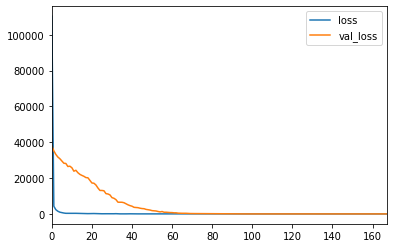

In [125]:
%matplotlib inline
pd.DataFrame(train_history.history).plot()

In [963]:
reviews

,business_id,user_id,stars,useful,funny,cool,date,name,restaurant_stars,review_count,categories,user_review_count,user_useful,user_funny,user_cool,fans,average_stars,bid,uid
1,3585,16135,4.0,1,0,0,2010-10-06 18:20:13,Carluccio's Tivoli Gardens,4.0,40,"[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,32,9,5,1,2.86,PZ-LZzSlhSe9utkQYU8pFg,jYcf_e5p0UG0S-9gJq_tNA
2,3585,17440,5.0,1,0,0,2010-01-13 00:35:45,Carluccio's Tivoli Gardens,4.0,40,"[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",18,34,16,2,0,3.89,PZ-LZzSlhSe9utkQYU8pFg,nQC0JiPIk_jCooRDxpuw5A
3,3585,6281,3.0,1,0,0,2008-08-23 20:30:33,Carluccio's Tivoli Gardens,4.0,40,"[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",149,170,59,81,24,4.05,PZ-LZzSlhSe9utkQYU8pFg,Gv_-mtOKhWFtCjn9xFe0SQ
4,3585,18189,3.0,1,0,0,2009-06-01 20:02:55,Carluccio's Tivoli Gardens,4.0,40,"[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",59,45,10,12,2,3.80,PZ-LZzSlhSe9utkQYU8pFg,pabMYegF28KjHQ5hybAJ0A
5,3585,5806,4.0,0,0,0,2010-05-22 16:54:57,Carluccio's Tivoli Gardens,4.0,40,"[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",401,436,118,107,9,3.60,PZ-LZzSlhSe9utkQYU8pFg,F_N4NyoMJWzBYFspeYfH3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386119,8019,3327,5.0,1,0,2,2012-10-05 22:04:07,Starbucks,3.0,138,"[2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",879,3457,1524,1927,105,3.56,vIAEWbTJc657yN8I4z7whQ,8QKrhvVqhEkD8xo4E4s0GQ
1386120,8019,3773,1.0,3,4,1,2015-04-01 04:34:41,Starbucks,3.0,138,"[2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",535,2969,1732,2032,102,3.84,vIAEWbTJc657yN8I4z7whQ,9ks-80ZxeCZWNObzEbW4-Q
1386121,8019,5313,3.0,0,0,0,2015-03-31 21:08:21,Starbucks,3.0,138,"[2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",116,122,41,18,2,2.06,vIAEWbTJc657yN8I4z7whQ,EA-UgJmd-hQ8RBn1odmDJg
1386122,8019,13509,5.0,0,0,0,2017-12-28 06:26:37,Starbucks,3.0,138,"[2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",48,52,20,33,4,3.58,vIAEWbTJc657yN8I4z7whQ,bcxc4OF5SDiJ4xnNMBZUQQ


In [964]:
weights = deep_fm_model.get_weights()
fm_1_weight, fm_2d_weigth, deep_weight = weights[-2]
print("""
contribution of different part of model
    weight of 1st order fm: %5.3f
    weight of 2nd order fm: %5.3f
    weight of dnn part: %5.3f
""" % (fm_1_weight, fm_2d_weigth, deep_weight))


contribution of different part of model
    weight of 1st order fm: 0.026
    weight of 2nd order fm: 0.021
    weight of dnn part: 1.116



In [130]:
deep_fm_model.save('deepFM_v0.1.h5')

In [135]:
predict_y = deep_fm_model.predict(valid_x)[:,0]
np.sqrt(sum((valid_y-predict_y)**2)/len(predict_y))

1.3723519731154

In [129]:
predict_y = deep_fm_model.predict(train_x)[:,0]
np.sqrt(sum((train_y-predict_y)**2)/len(predict_y))

0.41276623853582783

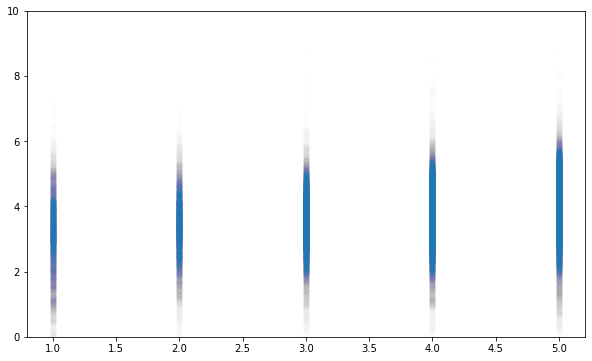

In [127]:
plt.figure(figsize=(10,6))
plt.ylim(0,10)
plt.scatter(valid_y, predict_y, alpha=0.005)
#plt.boxplot(valid_y, predict_y)

In [953]:
predict_y

array([3.9689913, 3.7850356, 3.84793  , ..., 5.002047 , 5.4247565,
       4.9941945], dtype=float32)

In [128]:
pd.DataFrame(predict_y).describe()

,0
count,54075.000000
mean,3.728723
std,1.011751
min,-6.409478
25%,3.179333
50%,3.807220
75%,4.389009
max,11.489264


In [210]:
valid_y

array([1., 4., 1., ..., 4., 5., 5.])

In [185]:
valid_x

[array([[1.067e+03, 1.650e+02, 2.000e+00, 1.810e+02, 7.000e+00, 1.700e+01],
        [1.300e+01, 1.300e+01, 1.100e+01, 4.000e+00, 8.000e+00, 3.540e+02],
        [2.000e+00, 1.900e+01, 2.000e+00, 3.000e+01, 3.500e+01, 1.400e+01],
        ...,
        [3.500e+00, 4.020e+00, 4.020e+00, 4.220e+00, 3.760e+00, 3.670e+00],
        [1.000e+00, 3.880e+00, 3.100e+00, 1.570e+00, 2.060e+00, 3.480e+00],
        [4.500e+00, 4.200e+00, 3.770e+00, 4.260e+00, 5.000e+00, 3.150e+00]]),
 array([4., 4., 4., ..., 3., 3., 3.]),
 array([ 40,  40, 107, ..., 138, 138, 138]),
 array([ 88774, 175885, 142471, ..., 416758, 208785, 288808], dtype=int32),
 array([3670, 3670, 2975, ..., 8215, 8215, 8215], dtype=int16),
 array([[ 1, 14,  0, ...,  0,  0,  0],
        [ 1, 14,  0, ...,  0,  0,  0],
        [ 3,  0,  0, ...,  0,  0,  0],
        ...,
        [ 2,  6,  0, ...,  0,  0,  0],
        [ 2,  6,  0, ...,  0,  0,  0],
        [ 2,  6,  0, ...,  0,  0,  0]])]

In [102]:
user_restaurant[user_restaurant['user_id']=='Nws4zPJP1n40BtufBUaI7Q']

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
21738,Nws4zPJP1n40BtufBUaI7Q,Scott,6,2014-08-24 07:25:39,12,4,3,,"ZXlqpWrwPBKIpwOYEVahzw, x0tSqnG-EhfHUniOc3ViSw...",1,5.0,1,0,0,0,0,0,0,0,0,0,0


In [289]:
final_k = pd.DataFrame({'business_id':reviews['business_id'].unique()})
final_review = final_k.merge(reviews[['business_id','name','bid','restaurant_stars','review_count','categories']], how='left',on='business_id')
final_review = final_review.drop_duplicates(subset=['business_id'])
final_user = reviews[reviews['uid']=='Nws4zPJP1n40BtufBUaI7Q'][['user_id','user_review_count','user_useful','user_funny','user_cool','fans','average_stars','stars']]
#final_user = user_restaurant[user_restaurant['user_id']=='Nws4zPJP1n40BtufBUaI7Q'][['user_id','user_review_count','user_useful','user_funny','user_cool','fans','average_stars','stars']]
final_user = final_user.drop_duplicates(subset=['user_id'])
final_review['key'] = 0
final_user['key'] = 0
final_df = final_review.merge(final_user, how='outer').drop(['key'],axis=1)
final_df

,business_id,name,bid,restaurant_stars,review_count,categories,key,user_id,user_review_count,user_useful,user_funny,user_cool,fans,average_stars,stars
0,3585,Carluccio's Tivoli Gardens,PZ-LZzSlhSe9utkQYU8pFg,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0
1,2916,Hunk Mansion,KWywu2tTEPWmR9JnBc0WyQ,4.0,107,"[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0
2,7806,Maria's Mexican Restaurant & Bakery,tstimHoMcYbkSC4eBA1wEg,4.5,184,"[1, 70, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0
3,6515,Dairy Queen,kANF0dbeoW34s2vwh6Umfw,2.0,33,"[4, 2, 1, 14, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0
4,4826,All Star Donuts & Kolaches,YK5eFV8uS1bCmp8GeiQ-Qg,4.0,6,"[2, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8650,5538,Great Steak & Potato,ckc3l8cSuggloG4NlquEFQ,2.0,5,"[1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0
8651,7022,Jessie Rae's BBQ,ngs16C2M_uTq2zXamltHVw,4.5,595,"[2, 22, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0
8652,976,99 Cents Only Stores,6A6wbLDM1wIG--6psAOqLQ,3.0,15,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0
8653,4049,Laguna Champagne Bar,SoPVLaoQlHuoZlt4fQBXTw,3.0,48,"[81, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0


In [290]:
final_train_x, final_train_y = df2xy(final_df)
final_predict_y = deep_fm_model.predict(final_train_x)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        3.000e+00, 1.200e+01, 1.060e+02, 6.480e+02, 2.318e+03, 3.176e+03,
        1.987e+03, 3.480e+02, 2.600e+01, 3.000e+00, 7.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

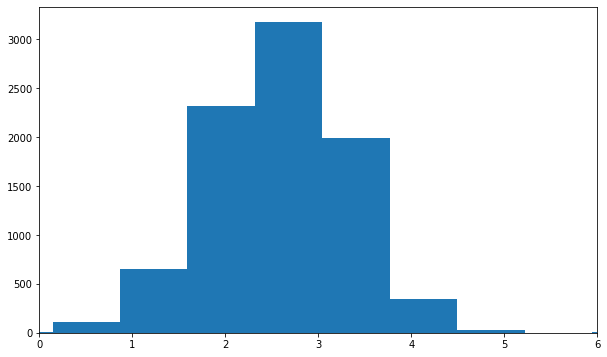

In [291]:
plt.figure(figsize=(10,6))
plt.xlim(0,6)
plt.hist(final_predict_y,bins=100)

In [292]:
#reviews[reviews['user_id']==21738].sort_values('stars',ascending=False)

In [293]:
final_predict_y

array([[3.539747 ],
       [2.9485137],
       [3.3844655],
       ...,
       [2.014477 ],
       [2.2803905],
       [3.1094224]], dtype=float32)

In [294]:
final_df['final_stars']=final_predict_y[:,0]
final_df

,business_id,name,bid,restaurant_stars,review_count,categories,key,user_id,user_review_count,user_useful,user_funny,user_cool,fans,average_stars,stars,final_stars
0,3585,Carluccio's Tivoli Gardens,PZ-LZzSlhSe9utkQYU8pFg,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,3.539747
1,2916,Hunk Mansion,KWywu2tTEPWmR9JnBc0WyQ,4.0,107,"[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,2.948514
2,7806,Maria's Mexican Restaurant & Bakery,tstimHoMcYbkSC4eBA1wEg,4.5,184,"[1, 70, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,3.384465
3,6515,Dairy Queen,kANF0dbeoW34s2vwh6Umfw,2.0,33,"[4, 2, 1, 14, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,1.581026
4,4826,All Star Donuts & Kolaches,YK5eFV8uS1bCmp8GeiQ-Qg,4.0,6,"[2, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,3.004434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8650,5538,Great Steak & Potato,ckc3l8cSuggloG4NlquEFQ,2.0,5,"[1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,1.530155
8651,7022,Jessie Rae's BBQ,ngs16C2M_uTq2zXamltHVw,4.5,595,"[2, 22, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,0.501917
8652,976,99 Cents Only Stores,6A6wbLDM1wIG--6psAOqLQ,3.0,15,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,2.014477
8653,4049,Laguna Champagne Bar,SoPVLaoQlHuoZlt4fQBXTw,3.0,48,"[81, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,2.280391


In [171]:
reviews[reviews['uid']=='Nws4zPJP1n40BtufBUaI7Q']

,business_id,user_id,stars,useful,funny,cool,date,name,restaurant_stars,review_count,categories,user_review_count,user_useful,user_funny,user_cool,fans,average_stars,bid,uid
9369,7927,2356,2.0,1,1,1,2009-06-24 09:16:18,The Buffet at Bellagio,3.5,4227,"[26, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",653,3222,2048,2491,132,3.76,ujHiaprwCQ5ewziu0Vi9rw,5TlkaYNie2xjv7nXW12Svg
154148,3822,2356,5.0,2,2,2,2013-07-08 03:59:56,Ice Pan,4.5,333,"[2, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",653,3222,2048,2491,132,3.76,RHi3Bn4HBGBp105LdVlZbQ,5TlkaYNie2xjv7nXW12Svg
408615,3366,2356,2.0,4,2,3,2010-01-17 07:58:18,Grand Lux Cafe,4.0,2767,"[2, 6, 1, 11, 0, 0, 0, 0, 0, 0, 0, 0]",653,3222,2048,2491,132,3.76,NvKNe9DnQavC9GstglcBJQ,5TlkaYNie2xjv7nXW12Svg
409433,3366,2356,4.0,1,1,1,2009-06-24 09:33:18,Grand Lux Cafe,4.0,2767,"[2, 6, 1, 11, 0, 0, 0, 0, 0, 0, 0, 0]",653,3222,2048,2491,132,3.76,NvKNe9DnQavC9GstglcBJQ,5TlkaYNie2xjv7nXW12Svg
496702,4276,2356,3.0,1,0,0,2009-06-24 08:45:46,Hot N Juicy Crawfish,4.0,1706,"[53, 1, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0]",653,3222,2048,2491,132,3.76,UNI1agsPX2k3eJSJVB91nw,5TlkaYNie2xjv7nXW12Svg
538916,2237,2356,4.0,1,1,1,2009-06-24 09:21:56,Carnival World Buffet,3.5,1380,"[26, 20, 1, 2, 9, 0, 0, 0, 0, 0, 0, 0]",653,3222,2048,2491,132,3.76,FLMxWQO-ckCQmGZhU9OQgw,5TlkaYNie2xjv7nXW12Svg
555306,1136,2356,4.0,0,0,0,2009-06-30 01:30:12,Buffalo Wild Wings,2.5,450,"[3, 22, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",653,3222,2048,2491,132,3.76,7Xw_vv-ekUL2sTqipnKT0g,5TlkaYNie2xjv7nXW12Svg
602199,2014,2356,5.0,3,2,3,2010-02-01 07:49:35,Earl of Sandwich,4.5,5075,"[20, 6, 33, 2, 1, 0, 0, 0, 0, 0, 0, 0]",653,3222,2048,2491,132,3.76,DkYS3arLOhA8si5uUEmHOw,5TlkaYNie2xjv7nXW12Svg
602500,2014,2356,5.0,2,0,2,2010-07-02 22:13:01,Earl of Sandwich,4.5,5075,"[20, 6, 33, 2, 1, 0, 0, 0, 0, 0, 0, 0]",653,3222,2048,2491,132,3.76,DkYS3arLOhA8si5uUEmHOw,5TlkaYNie2xjv7nXW12Svg
729999,657,2356,5.0,3,2,3,2010-01-17 22:26:10,Bouchon Bakery at the Venetian Theater,4.0,1152,"[11, 2, 6, 13, 1, 0, 0, 0, 0, 0, 0, 0]",653,3222,2048,2491,132,3.76,3uC7Lbc3RgUDTWQlBu4PqQ,5TlkaYNie2xjv7nXW12Svg


In [295]:
final_df.sort_values('final_stars',ascending=False)[:10]

,business_id,name,bid,restaurant_stars,review_count,categories,key,user_id,user_review_count,user_useful,user_funny,user_cool,fans,average_stars,stars,final_stars
7837,1571,Luxor Hotel and Casino Las Vegas,AV6weBrZFFBfRGCbcRGO4g,2.5,4117,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,53.799423
8462,1762,Stratosphere,ByFMv3p5X1aNeZhU61rDcA,2.5,2042,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,26.908102
8275,7904,Treasure Island,uanCi4OGc1mHLGl_AT4JhQ,3.0,2487,"[3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,21.204420
7865,530,The Buffet,2weQS-RnoOBhb1KsHKyoSQ,3.5,4400,"[2, 26, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,18.864439
8474,2530,Senor Frog's,HWl2EbZhkhAkFgqt44yUkA,2.5,883,"[25, 1, 24, 3, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,13.391256
8492,4241,Beijing Noodle No. 9,U9aA5H13y7t9xWnoQslV0Q,2.5,876,"[2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,13.098063
7996,2451,Stacks & Yolks,Gt4z3AylNTsEPDkzkaC7HA,3.0,959,"[8, 2, 1, 9, 6, 63, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,11.467333
8466,5616,White Castle,dKdApYVFDSNYsNOso6NYlA,3.0,1195,"[4, 8, 1, 9, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,11.105833
7803,4694,Cracker Barrel Old Country Store,XQJr9_jZR1vOoZVcZfDDwQ,3.0,816,"[30, 2, 1, 43, 9, 11, 20, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,10.052504
8550,7129,Chayo Mexican Kitchen + Tequila Bar,oXoVJ0xKv82cBo9U6oEjlQ,3.5,1487,"[9, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,123,20,88,73,31,1,3.82,5.0,8.947760


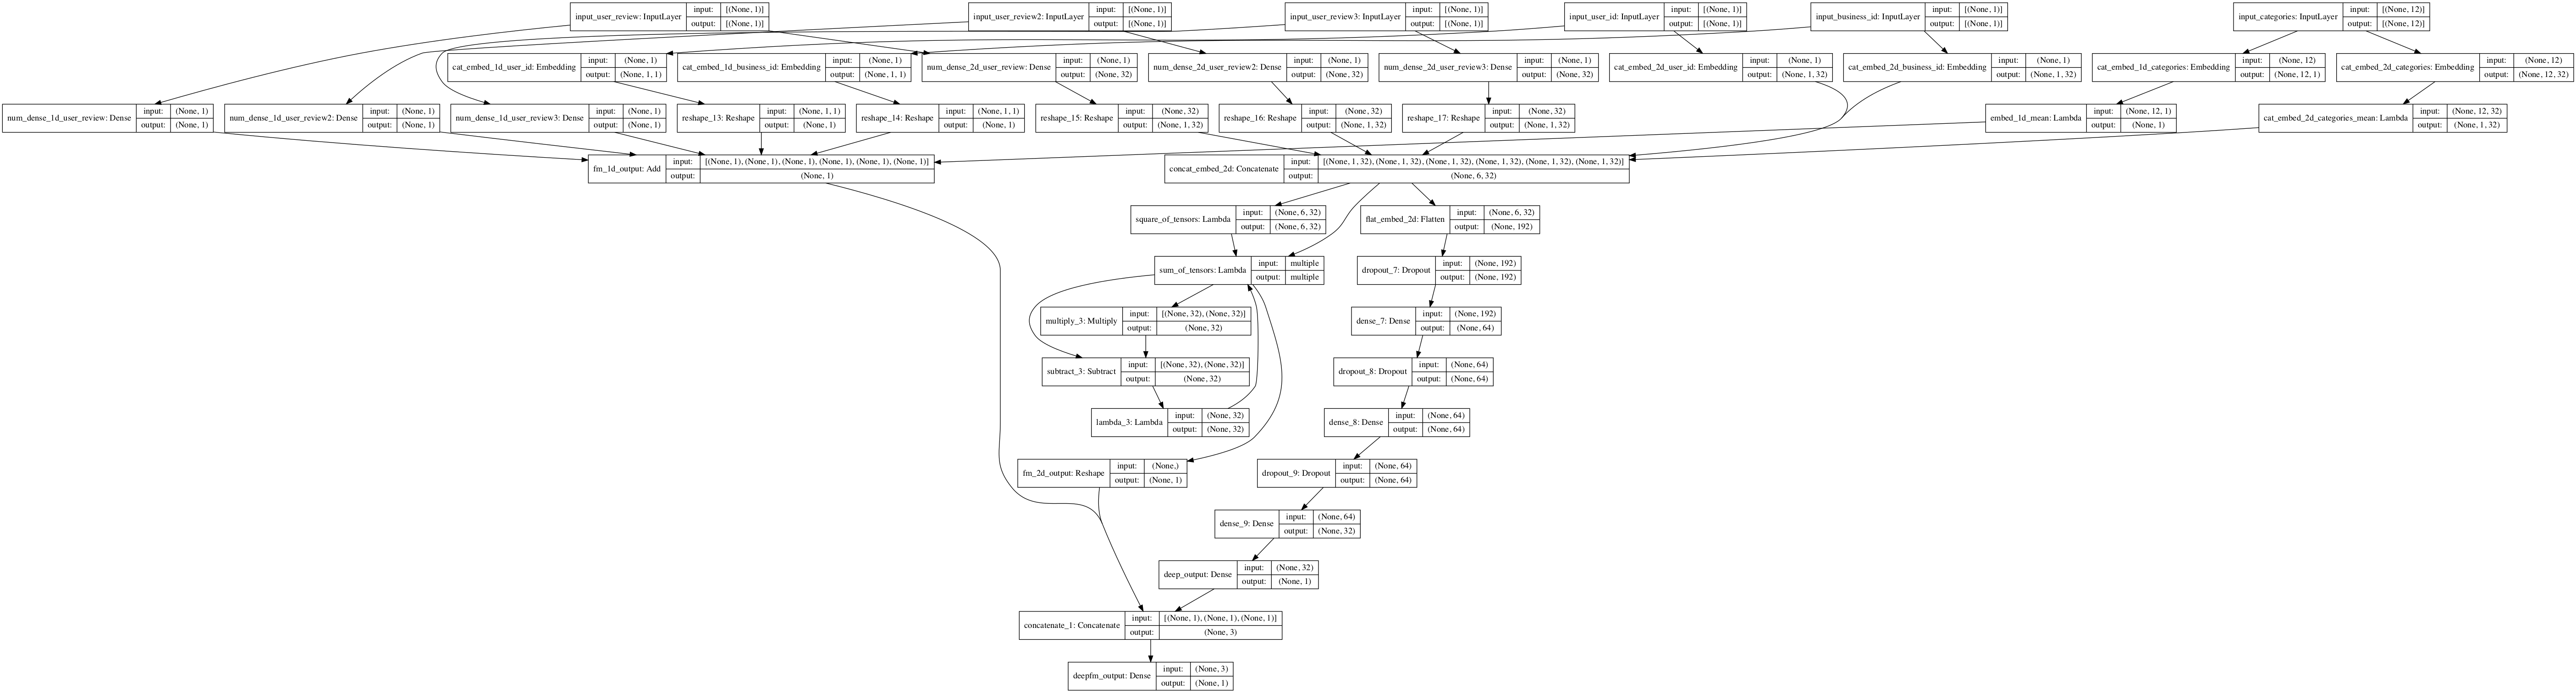

In [206]:
!rm -rf image
!mkdir image
from tensorflow.keras.utils import plot_model
plot_model(fm_model_1d, to_file='./image/fm_model_1d.png',show_shapes=True, show_layer_names=True)
plot_model(fm_model_2d, to_file='./image/fm_model_2d.png',show_shapes=True, show_layer_names=True)
plot_model(deep_model, to_file='./image/deep_model.png',show_shapes=True, show_layer_names=True)
plot_model(deep_fm_model, to_file='./image/deep_fm_model.png',show_shapes=True, show_layer_names=True)

In [141]:
review_restaurant

,business_id,review_id,user_id,stars,useful,funny,cool,text,date
1,PZ-LZzSlhSe9utkQYU8pFg,Li-pQG6A7p5gbgZHTMeDSQ,jYcf_e5p0UG0S-9gJq_tNA,4.0,1,0,0,i had the best Chicken Marcela ever. The spagh...,2010-10-06 18:20:13
2,PZ-LZzSlhSe9utkQYU8pFg,iRLX3dJ3ONvncIxPnXy1cw,nQC0JiPIk_jCooRDxpuw5A,5.0,1,0,0,Basically the best Italian in town for the pri...,2010-01-13 00:35:45
3,PZ-LZzSlhSe9utkQYU8pFg,rklteWf9xnTU3fAtMFBRRw,Gv_-mtOKhWFtCjn9xFe0SQ,3.0,1,0,0,Mmmmm delicious food and a little history. Mr....,2008-08-23 20:30:33
4,PZ-LZzSlhSe9utkQYU8pFg,UfRqM0RGdZa86hFcFEAnjw,pabMYegF28KjHQ5hybAJ0A,3.0,1,0,0,"This is old Vegas, this atmosphere is old scho...",2009-06-01 20:02:55
5,PZ-LZzSlhSe9utkQYU8pFg,1RtC0WIuMR5x88uoFOPyEA,F_N4NyoMJWzBYFspeYfH3A,4.0,0,0,0,"Heavy on the atmosphere, heavy on the red sauc...",2010-05-22 16:54:57
...,...,...,...,...,...,...,...,...,...
1386119,vIAEWbTJc657yN8I4z7whQ,-SEmE5vSGN8VDUF18JRczA,8QKrhvVqhEkD8xo4E4s0GQ,5.0,1,0,2,The Baristas rock here! I stop in on my way to...,2012-10-05 22:04:07
1386120,vIAEWbTJc657yN8I4z7whQ,-sx8tpdUukgvh0uByg4DBQ,9ks-80ZxeCZWNObzEbW4-Q,1.0,3,4,1,This is THE worst Starbucks I've ever been to....,2015-04-01 04:34:41
1386121,vIAEWbTJc657yN8I4z7whQ,82qiOWCRRPTjRcxcIq018g,EA-UgJmd-hQ8RBn1odmDJg,3.0,0,0,0,The guy here at window just turned this whole ...,2015-03-31 21:08:21
1386122,vIAEWbTJc657yN8I4z7whQ,4U49OBNRHvjm62hcBEKy2A,bcxc4OF5SDiJ4xnNMBZUQQ,5.0,0,0,0,I honestly don't know why this location has su...,2017-12-28 06:26:37


---------------------------------
### Factorization Machine using xlearn

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [251]:
xreviews = reviews.copy()
xreviews

,business_id,user_id,stars,useful,funny,cool,date,name,restaurant_stars,review_count,categories,user_review_count,user_useful,user_funny,user_cool,fans,average_stars,bid,uid
1,3585,16135,4.0,1,0,0,2010-10-06 18:20:13,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,32,9,5,1,2.86,PZ-LZzSlhSe9utkQYU8pFg,jYcf_e5p0UG0S-9gJq_tNA
2,3585,17440,5.0,1,0,0,2010-01-13 00:35:45,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",18,34,16,2,0,3.89,PZ-LZzSlhSe9utkQYU8pFg,nQC0JiPIk_jCooRDxpuw5A
3,3585,6281,3.0,1,0,0,2008-08-23 20:30:33,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",149,170,59,81,24,4.05,PZ-LZzSlhSe9utkQYU8pFg,Gv_-mtOKhWFtCjn9xFe0SQ
4,3585,18189,3.0,1,0,0,2009-06-01 20:02:55,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",59,45,10,12,2,3.80,PZ-LZzSlhSe9utkQYU8pFg,pabMYegF28KjHQ5hybAJ0A
5,3585,5806,4.0,0,0,0,2010-05-22 16:54:57,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",401,436,118,107,9,3.60,PZ-LZzSlhSe9utkQYU8pFg,F_N4NyoMJWzBYFspeYfH3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386119,8019,3327,5.0,1,0,2,2012-10-05 22:04:07,Starbucks,3.0,138,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",879,3457,1524,1927,105,3.56,vIAEWbTJc657yN8I4z7whQ,8QKrhvVqhEkD8xo4E4s0GQ
1386120,8019,3773,1.0,3,4,1,2015-04-01 04:34:41,Starbucks,3.0,138,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",535,2969,1732,2032,102,3.84,vIAEWbTJc657yN8I4z7whQ,9ks-80ZxeCZWNObzEbW4-Q
1386121,8019,5313,3.0,0,0,0,2015-03-31 21:08:21,Starbucks,3.0,138,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",116,122,41,18,2,2.06,vIAEWbTJc657yN8I4z7whQ,EA-UgJmd-hQ8RBn1odmDJg
1386122,8019,13509,5.0,0,0,0,2017-12-28 06:26:37,Starbucks,3.0,138,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",48,52,20,33,4,3.58,vIAEWbTJc657yN8I4z7whQ,bcxc4OF5SDiJ4xnNMBZUQQ


In [66]:
xreviews[['useful','funny','cool','review_count','user_review_count','fans','average_stars']].apply(lambda x:print(x.value_counts()))

0.0      240842
1.0      118917
2.0       62736
3.0       35223
4.0       21729
5.0       14091
6.0        9858
7.0        7040
8.0        5359
9.0        4059
10.0       3214
11.0       2427
12.0       2019
13.0       1627
14.0       1339
15.0       1101
16.0        931
17.0        784
18.0        703
19.0        649
20.0        524
21.0        481
22.0        434
23.0        399
24.0        350
25.0        318
26.0        291
27.0        253
28.0        240
29.0        214
30.0        190
31.0        189
32.0        180
33.0        152
34.0        138
35.0        131
36.0        109
37.0        105
38.0        102
39.0        100
40.0         79
42.0         67
44.0         64
46.0         61
43.0         61
41.0         60
47.0         48
49.0         40
45.0         38
51.0         36
50.0         33
48.0         31
53.0         26
52.0         26
63.0         24
55.0         23
60.0         22
58.0         22
54.0         20
56.0         18
62.0         18
59.0         17
67.0    

useful               None
funny                None
cool                 None
review_count         None
user_review_count    None
fans                 None
average_stars        None
dtype: object

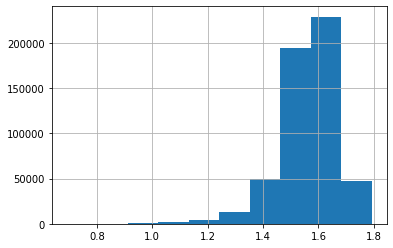

In [67]:
np.log1p(xreviews['average_stars']).hist()

In [113]:
xreviews

,business_id,user_id,stars,useful,funny,cool,date,name,restaurant_stars,review_count,categories,user_review_count,user_useful,user_funny,user_cool,fans,average_stars,bid,uid
1,3585,16135,4.0,1,0,0,2010-10-06 18:20:13,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,32,9,5,1,2.86,PZ-LZzSlhSe9utkQYU8pFg,jYcf_e5p0UG0S-9gJq_tNA
2,3585,17440,5.0,1,0,0,2010-01-13 00:35:45,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",18,34,16,2,0,3.89,PZ-LZzSlhSe9utkQYU8pFg,nQC0JiPIk_jCooRDxpuw5A
3,3585,6281,3.0,1,0,0,2008-08-23 20:30:33,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",149,170,59,81,24,4.05,PZ-LZzSlhSe9utkQYU8pFg,Gv_-mtOKhWFtCjn9xFe0SQ
4,3585,18189,3.0,1,0,0,2009-06-01 20:02:55,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",59,45,10,12,2,3.80,PZ-LZzSlhSe9utkQYU8pFg,pabMYegF28KjHQ5hybAJ0A
5,3585,5806,4.0,0,0,0,2010-05-22 16:54:57,Carluccio's Tivoli Gardens,4.0,40,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",401,436,118,107,9,3.60,PZ-LZzSlhSe9utkQYU8pFg,F_N4NyoMJWzBYFspeYfH3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386119,8019,3327,5.0,1,0,2,2012-10-05 22:04:07,Starbucks,3.0,138,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",879,3457,1524,1927,105,3.56,vIAEWbTJc657yN8I4z7whQ,8QKrhvVqhEkD8xo4E4s0GQ
1386120,8019,3773,1.0,3,4,1,2015-04-01 04:34:41,Starbucks,3.0,138,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",535,2969,1732,2032,102,3.84,vIAEWbTJc657yN8I4z7whQ,9ks-80ZxeCZWNObzEbW4-Q
1386121,8019,5313,3.0,0,0,0,2015-03-31 21:08:21,Starbucks,3.0,138,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",116,122,41,18,2,2.06,vIAEWbTJc657yN8I4z7whQ,EA-UgJmd-hQ8RBn1odmDJg
1386122,8019,13509,5.0,0,0,0,2017-12-28 06:26:37,Starbucks,3.0,138,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",48,52,20,33,4,3.58,vIAEWbTJc657yN8I4z7whQ,bcxc4OF5SDiJ4xnNMBZUQQ


In [252]:
xreviews[['useful','funny','cool','review_count','user_review_count','user_useful','user_funny','user_cool','fans']] = xreviews[['useful','funny','cool','review_count','user_review_count','user_useful','user_funny','user_cool','fans']].apply(lambda x: np.log1p(x))
xreviews[['useful','funny','cool','review_count','user_review_count','user_useful','user_funny','user_cool','fans']] = xreviews[['useful','funny','cool','review_count','user_review_count','user_useful','user_funny','user_cool','fans']].apply(lambda x: pd.cut(x,10,labels=False))
xreviews[['useful','funny','cool','review_count','user_review_count','user_useful','user_funny','user_cool','fans']] = xreviews[['useful','funny','cool','review_count','user_review_count','user_useful','user_funny','user_cool','fans']].apply(lambda x: (x+1).astype(str))
xreviews.drop(['business_id','user_id','date','name','restaurant_stars'], axis=1, inplace=True)
xreviews

,stars,useful,funny,cool,review_count,categories,user_review_count,user_useful,user_funny,user_cool,fans,average_stars,bid,uid
1,4.0,2,1,1,4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2,3,2,2,1,2.86,PZ-LZzSlhSe9utkQYU8pFg,jYcf_e5p0UG0S-9gJq_tNA
2,5.0,2,1,1,4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2,3,3,1,1,3.89,PZ-LZzSlhSe9utkQYU8pFg,nQC0JiPIk_jCooRDxpuw5A
3,3.0,2,1,1,4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,5,4,4,5,4.05,PZ-LZzSlhSe9utkQYU8pFg,Gv_-mtOKhWFtCjn9xFe0SQ
4,3.0,2,1,1,4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4,4,3,3,2,3.80,PZ-LZzSlhSe9utkQYU8pFg,pabMYegF28KjHQ5hybAJ0A
5,4.0,1,1,1,4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",6,6,5,4,3,3.60,PZ-LZzSlhSe9utkQYU8pFg,F_N4NyoMJWzBYFspeYfH3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386119,5.0,2,1,2,5,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",7,7,7,7,6,3.56,vIAEWbTJc657yN8I4z7whQ,8QKrhvVqhEkD8xo4E4s0GQ
1386120,1.0,3,4,2,5,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",6,7,7,7,6,3.84,vIAEWbTJc657yN8I4z7whQ,9ks-80ZxeCZWNObzEbW4-Q
1386121,3.0,1,1,1,5,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5,5,4,3,2,2.06,vIAEWbTJc657yN8I4z7whQ,EA-UgJmd-hQ8RBn1odmDJg
1386122,5.0,1,1,1,5,"[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,4,3,3,3,3.58,vIAEWbTJc657yN8I4z7whQ,bcxc4OF5SDiJ4xnNMBZUQQ


#### make dataframe to sparse matrix

In [253]:
field_dict = {'Restaurant': '0',
              'User': '1',
              'Category': '2'}
mapping_dict = {'useful': 'Restaurant', 'funny': 'Restaurant', 'cool':'Restaurant','review_count':'Restaurant',
                'user_review_count': 'User', 'user_useful': 'User', 'user_funny':'User','user_cool':'User','fans':'User','average_stars':'User',
                'categories': 'Category'}
col_len_dict = {'useful':10,'funny':10,'cool':10,'review_count':10,'categories':88,'user_review_count':10,'user_useful':10,'user_funny':10,'user_cool':10,'fans':10,'average_stars':1}
col_accum_index_dict = {}
cumulative = 0
for key, value in col_len_dict.items():
    col_accum_index_dict[key] = cumulative
    cumulative = cumulative + value

train_df, test_df = train_test_split(xreviews, test_size=0.2)

In [254]:
txt_file = open('xlearn_dataset/train.txt', 'w')
for idx, row in train_df.iterrows():
    vec = []
    label = row['stars']
    vec.append(str(label))
    row = row.drop(labels=['stars','bid','uid'])
    for key, value in row.items():
        if key == 'average_stars':
            col_idx = col_accum_index_dict[key]
            out_val = value
            vec.append(field_dict[mapping_dict[key]] + ":" + str(col_idx) + ":" + str(out_val))
        if key == 'categories':
            col_idx = col_accum_index_dict[key] - 1
            out_val = 1
            [vec.append(field_dict[mapping_dict[key]] + ":" + str(col_idx+n) + ":" + str(out_val)) for n in value if n >0]
        else:
            col_idx = col_accum_index_dict[key] + (int(value) - 1)
            out_val = 1
            vec.append(field_dict[mapping_dict[key]] + ":" + str(col_idx) + ":" + str(out_val))
    txt_file.write("%s\n" % " ".join(vec))
    
txt_file.close()

In [255]:
txt_file = open('xlearn_dataset/test.txt', 'w')
for idx, row in test_df.iterrows():
    vec = []
    label = row['stars']
    vec.append(str(label))
    row = row.drop(labels=['stars','bid','uid'])
    for key, value in row.items():
        if key == 'average_stars':
            col_idx = col_accum_index_dict[key]
            out_val = value
            vec.append(field_dict[mapping_dict[key]] + ":" + str(col_idx) + ":" + str(out_val))
        if key == 'categories':
            col_idx = col_accum_index_dict[key] - 1
            out_val = 1
            [vec.append(field_dict[mapping_dict[key]] + ":" + str(col_idx+n) + ":" + str(out_val)) for n in value if n >0]
        else:
            col_idx = col_accum_index_dict[key] + (int(value) - 1)
            out_val = 1
            vec.append(field_dict[mapping_dict[key]] + ":" + str(col_idx) + ":" + str(out_val))
    txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

#### to make predict set

In [183]:
xreviews

,stars,useful,funny,cool,review_count,user_review_count,user_useful,user_funny,user_cool,fans,average_stars,bid,uid
1,4.0,2,1,1,40,21,1,3,2,2,2.86,PZ-LZzSlhSe9utkQYU8pFg,jYcf_e5p0UG0S-9gJq_tNA
2,5.0,2,1,1,40,18,1,3,3,1,3.89,PZ-LZzSlhSe9utkQYU8pFg,nQC0JiPIk_jCooRDxpuw5A
3,3.0,2,1,1,40,149,5,5,4,4,4.05,PZ-LZzSlhSe9utkQYU8pFg,Gv_-mtOKhWFtCjn9xFe0SQ
4,3.0,2,1,1,40,59,2,4,3,3,3.80,PZ-LZzSlhSe9utkQYU8pFg,pabMYegF28KjHQ5hybAJ0A
5,4.0,1,1,1,40,401,3,6,5,4,3.60,PZ-LZzSlhSe9utkQYU8pFg,F_N4NyoMJWzBYFspeYfH3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386119,5.0,2,1,2,138,879,6,7,7,7,3.56,vIAEWbTJc657yN8I4z7whQ,8QKrhvVqhEkD8xo4E4s0GQ
1386120,1.0,3,4,2,138,535,6,7,7,7,3.84,vIAEWbTJc657yN8I4z7whQ,9ks-80ZxeCZWNObzEbW4-Q
1386121,3.0,1,1,1,138,116,2,5,4,3,2.06,vIAEWbTJc657yN8I4z7whQ,EA-UgJmd-hQ8RBn1odmDJg
1386122,5.0,1,1,1,138,48,3,4,3,3,3.58,vIAEWbTJc657yN8I4z7whQ,bcxc4OF5SDiJ4xnNMBZUQQ


In [184]:
predict_df = xreviews[['useful','funny','cool','review_count','bid']]
predict_df = predict_df.drop_duplicates(subset=['bid'])
predict_user_df = xreviews[xreviews['uid']=='TglAI9psHTtSRoI7TbttcQ'][['stars','user_review_count','user_useful','user_funny','user_cool','fans','average_stars','uid']]
predict_user_df = predict_user_df.drop_duplicates(subset=['uid'])
predict_df['key'] = 0
predict_user_df['key'] = 0
predict_df = predict_df.merge(predict_user_df, how='outer')

In [166]:
txt_file = open('xlearn_dataset/predict.txt', 'w')
for idx, row in predict_df.iterrows():
    vec = []
    label = row['stars']
    vec.append(str(label))
    row = row.drop(labels=['stars','bid','uid','key'])
    for key, value in row.items():
        if (key == 'review_count') or (key == 'user_review_count'):
            col_idx = col_accum_index_dict[key]
            out_val = value
            vec.append(field_dict[mapping_dict[key]] + ":" + str(col_idx) + ":" + str(out_val))
        elif key == 'categories':
            col_idx = col_accum_index_dict[key] - 1
            out_val = 1
            [vec.append(field_dict[mapping_dict[key]] + ":" + str(col_idx+n) + ":" + str(out_val)) for n in value if n >0]
        else:
            col_idx = col_accum_index_dict[key] + (int(value) - 1)
            out_val = 1
            vec.append(field_dict[mapping_dict[key]] + ":" + str(col_idx) + ":" + str(out_val))
    txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

In [167]:
predict_df = xreviews[['useful','funny','cool','review_count','bid']]
predict_df = predict_df.drop_duplicates(subset=['bid'])
predict_df

,useful,funny,cool,review_count,bid
1,2,1,1,40,PZ-LZzSlhSe9utkQYU8pFg
82,5,3,1,107,KWywu2tTEPWmR9JnBc0WyQ
158,1,1,1,184,tstimHoMcYbkSC4eBA1wEg
340,2,1,1,33,kANF0dbeoW34s2vwh6Umfw
374,4,1,1,6,YK5eFV8uS1bCmp8GeiQ-Qg
...,...,...,...,...,...
1385288,1,2,1,5,ckc3l8cSuggloG4NlquEFQ
1385293,1,1,1,595,ngs16C2M_uTq2zXamltHVw
1385907,2,3,1,15,6A6wbLDM1wIG--6psAOqLQ
1385923,2,1,2,48,SoPVLaoQlHuoZlt4fQBXTw


#### train

In [263]:
import xlearn as xl

def test():
    fm_model = xl.create_fm()

    train_path = 'xlearn_dataset/train.txt'
    test_path = 'xlearn_dataset/test.txt'
    predict_path = 'xlearn_dataset/predict.txt'

    fm_model.setTrain(train_path)
    fm_model.setValidate(test_path)

    # Parameters:
    param = {'task':'reg',
             'epoch': 50,
             'lr':0.01,
             'lambda':0.02,
             'metric': 'rmse', 
             'opt':'sgd',
             'stop_window':5,
             'fold':5}

    # Start to train
    # The trained model will be stored in model.out
    fm_model.fit(param, 'xlearn_dataset/model.out')
    fm_model.setTXTModel('xlearn_dataset/model.txt')

    # Prediction task
    fm_model.setTest(test_path)  # Set the path of test dataset
    #fm_model.setSigmoid()                 # Convert output to 0-1

    # Start to predict
    # The output result will be stored in output.txt
    fm_model.predict("xlearn_dataset/model.out", "xlearn_dataset/output.txt")

In [267]:
test()

In [268]:
result = pd.read_csv('xlearn_dataset/output.txt', header=None)

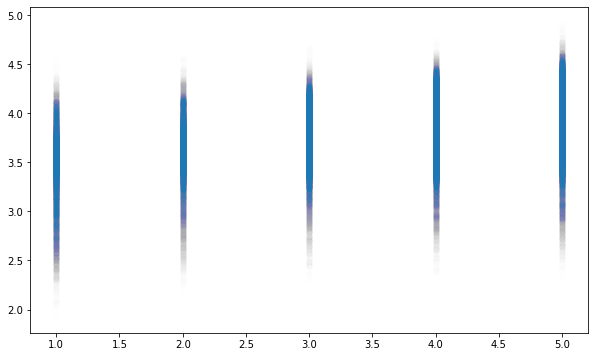

In [269]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(test_df.stars, result[0], alpha=0.002)

In [151]:
np.sqrt(sum((test_df.stars.values - result[0].values)**2)/len(result[0].values))

1.228697451894976

In [156]:
result[0].values

array([3.94559, 3.88882, 3.8305 , ..., 3.96073, 3.97467, 3.72071])

In [157]:
predict_df['final_stars'] = result[0].values
predict_df

ValueError: Length of values does not match length of index

In [158]:
restaurant.merge(predict_df[['bid','final_stars']].rename(columns={'bid': 'business_id'}),on='business_id').sort_values('final_stars',ascending=False).head(10)

KeyError: "['final_stars'] not in index"

In [111]:
business[business['business_id'].isin(review[review['user_id']=='TglAI9psHTtSRoI7TbttcQ'].sort_values('stars',ascending=False).head(10)['business_id'])].sort_values('stars',ascending=False)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,attributes.GoodForKids,attributes.RestaurantsReservations,attributes.Caters,attributes.NoiseLevel,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.RestaurantsPriceRange2,attributes.OutdoorSeating,attributes.BikeParking,attributes.HasTV,attributes.WiFi,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsGoodForGroups,attributes.RestaurantsDelivery,hours.Monday,hours.Tuesday,hours.Wednesday,hours.Thursday,hours.Friday,hours.Saturday,hours.Sunday,attributes.GoodForMeal.dessert,attributes.GoodForMeal.latenight,attributes.GoodForMeal.lunch,attributes.GoodForMeal.dinner,attributes.GoodForMeal.brunch,attributes.GoodForMeal.breakfast,attributes.BusinessParking.garage,attributes.BusinessParking.street,attributes.BusinessParking.validated,attributes.BusinessParking.lot,attributes.BusinessParking.valet,attributes.Ambience.romantic,attributes.Ambience.intimate,attributes.Ambience.classy,attributes.Ambience.hipster,attributes.Ambience.divey,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.Ambience.casual,attributes.BusinessAcceptsCreditCards,attributes.BusinessAcceptsBitcoin,attributes.ByAppointmentOnly,attributes.AcceptsInsurance,attributes.GoodForDancing,attributes.CoatCheck,attributes.HappyHour,attributes.Music.dj,attributes.Music.background_music,attributes.Music.no_music,attributes.Music.jukebox,attributes.Music.live,attributes.Music.video,attributes.Music.karaoke,attributes.BestNights.monday,attributes.BestNights.tuesday,attributes.BestNights.friday,attributes.BestNights.wednesday,attributes.BestNights.thursday,attributes.BestNights.sunday,attributes.BestNights.saturday,attributes.Ambience,attributes.BusinessParking,attributes.WheelchairAccessible,attributes.DogsAllowed,attributes.BYOBCorkage,attributes.DriveThru,attributes.Smoking,attributes.AgesAllowed,attributes.HairSpecializesIn.straightperms,attributes.HairSpecializesIn.coloring,attributes.HairSpecializesIn.extensions,attributes.HairSpecializesIn.africanamerican,attributes.HairSpecializesIn.curly,attributes.HairSpecializesIn.kids,attributes.HairSpecializesIn.perms,attributes.HairSpecializesIn.asian,attributes.Corkage,attributes.BYOB,attributes.GoodForMeal,attributes.Music,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.gluten-free,attributes.DietaryRestrictions.vegan,attributes.DietaryRestrictions.kosher,attributes.DietaryRestrictions.halal,attributes.DietaryRestrictions.soy-free,attributes.DietaryRestrictions.vegetarian,attributes.BestNights,attributes.HairSpecializesIn,attributes.Open24Hours,attributes.DietaryRestrictions,attributes.RestaurantsCounterService
117323,XlYPCgekrmLAz4l4mTQBTw,Anytime Electric,,Las Vegas,NV,89117,36.145333,-115.277832,5.0,68,1,"Electricians, TV Mounting, Lighting Fixtures &...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0:0-0:0,7:0-19:0,7:0-19:0,7:0-19:0,7:0-19:0,7:0-19:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126425,o6WDADPp8T7h4hrdWv7X8w,MaxRelax Massage & Bodywork By Tony,"2490 Paseo Verde, Ste 100",Henderson,NV,89074,36.019927,-115.095801,5.0,66,1,"Beauty & Spas, Massage",NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9:0-14:30,9:0-14:30,9:0-14:30,9:0-14:30,9:0-14:30,9:0-15:30,NaN,NaN,NaN,NaN,NaN,NaN,False,True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143000,bjg8lkT_rWHpE87j6aODFQ,Vegas Valley Air,,Las Vegas,NV,89135

-----------------------------
### enssemble

In [300]:
#np.expm1(reviews['restaurant_stars'])

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()
deepfm_df['deepfm_final_score'] = scaler.fit_transform(deepfm_df[['deepfm_final_score']])
xlearn_df['xlearn_final_score'] = scaler.fit_transform(xlearn_df[['xlearn_final_score']])
final_df = final_df.merge(deepfm_df,on='business_id',how='left').merge(xlearn_df, on='business_id',how='left')
final_df['final_score'] = final_df['deepfm_final_score'] * 0.3 + final_df['xlearn_final_score'] * 0.7
final_df = final_df.sort_values('final_score',ascending=False)